In [1]:
import nilearn.image, nilearn.decoding
import nibabel as nib
import numpy as np
import numpy.linalg as linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import plotly.express as px #interactive-plot
from tqdm import tqdm # precessing-bar
import cufflinks as cf
from plotly.offline import iplot
cf.go_offline()
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from PCRegression import PCR


/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


# IF Condition


In [5]:
# Ver. Local
# python >= 3.6 -> fString
def getColPos_IF(subj_id,df=False):
    ex_group= {'WG_P1P2' : ['IF02', 'IF03', 'IF04', 'IF07'],
               'WG_P2P1' : ['IF05', 'IF06', 'IF08', 'IF10'],
               'GW_P1P2' : ['IF12', 'IF15'],
               'GW_P2P1' : ['IF13', 'IF14']}
    if df:
        ex_color={'WG':['White','Gray','White','Gray'],'GW':['Gray','White','Gray','White']}
        ex_pos={'P1P2':['x','x','+','+'],'P2P1':['+','+','x','x']}
    else:
        ex_color={'WG':[0,1,0,1],'GW':[1,0,1,0]}
        ex_pos={'P1P2':[0,0,1,1],'P2P1':[1,1,0,0]}
    ColPos=[keys for keys in ex_group if subj_id in ex_group[keys]][0]
    color=ex_color[ColPos[:2]]
    pos=ex_pos[ColPos[3:]]
    return color, pos

def load_Beta_IF(subj_id, run_n):
    data_dir=f'/Volumes/clmnlab/G7T/main/fmri_data/glm_results/G7T_{subj_id}/LSSpb04_unmask/betasLSS.G7T_{subj_id}.run0{run_n}.nii.gz'
    img = nilearn.image.load_img(data_dir)
    return img

def load_Beta_IF_1s(subj_id, run_n):
    data_dir=f'/Volumes/clmnlab/G7T/main/fmri_data/glm_results/G7T_{subj_id}/LSSpb04_unmask_1s/betasLSS1s.G7T_{subj_id}.run0{run_n}.nii.gz'
    img = nilearn.image.load_img(data_dir)
    return img

def load_Behavior_IF(subj_id, run_n):
    group_id=subj_id[0:2]
    Subj_id=group_id+subj_id[-2:]
    EL = subj_id[2]
    regressor_dir=f'/Volumes/clmnlab/G7T/main/fmri_data/regressors/G7T_{group_id}/G7T_{subj_id}/totalReward_run0{run_n}.txt'
    hit_Dat=pd.read_csv(regressor_dir,sep=' ',header=None).T.rename(columns={0:'hit'})
    handpos=pd.DataFrame({'hand':['R']*(len(hit_Dat)),
                          'position':[0,0,1,1]*(len(hit_Dat)//4),
                          'trial':np.repeat(list(range(1,21)),2),
                          'mapping':[0,1,0,1]*(len(hit_Dat)//4),
                         'EarlyLate':[EL]*len(hit_Dat)})
    [group_color,group_position]=getColPos_IF(Subj_id,True)
    colpos=pd.DataFrame({'colorGroup':group_color*(len(hit_Dat)//4),'posGroup':group_position*(len(hit_Dat)//4)})
    y_dat=pd.concat([hit_Dat,handpos,colpos],axis=1)
    return y_dat

def totalize_behaviorIF(subj_id, runlist):
    bavDat=load_BehaviorIF(subj_id, runlist[0]).assign(session=runlist[0])
    for i in runlist[1:]:
        bavDat0=load_BehaviorIF(subj_id, i).assign(session=i)
        bavDat=pd.concat([bavDat,bavDat0])
    return bavDat

def get_XYG_IF(subj_id, runlist,target):
    Xs = [load_Beta_IF(subj_id, run) for run in runlist]
    Ys = [load_HitN_IF(subj_id, run, target) for run in runlist]
    
    group = [i for i, y in enumerate(Ys) for j in range(len(y))]
    
    xDat = nilearn.image.concat_imgs(Xs)
    yDat = np.concatenate(Ys)
    
    assert xDat.shape[-1] == yDat.shape[0]
    assert yDat.shape[0] == len(group)
    
    return xDat, yDat, group

def get_XYG_IF_1s(subj_id, runlist,target):
    Xs = [load_Beta_IF_1s(subj_id, run) for run in runlist]
    Ys = [load_HitN_IF(subj_id, run, target) for run in runlist]
    
    group = [i for i, y in enumerate(Ys) for j in range(len(y))]
    
    xDat = nilearn.image.concat_imgs(Xs)
    yDat = np.concatenate(Ys)
    
    assert xDat.shape[-1] == yDat.shape[0]
    assert yDat.shape[0] == len(group)
    
    return xDat, yDat, group

# ROI Fan Mask Setting
def num2str3(num):
    numstr=str(num)
    zerolen=3-len(numstr)
    str3='0'*zerolen+numstr
    return str3
fanlist=['Fan_resam'+num2str3(i)+'.nii' for i in range(1,281)]

def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError(f'different shape while masking! img={img_data.shape} and roi={roi_mask.shape}')
    return img_data[roi_mask, :].T

def load_HitN_IF(subj_id, run_n, target):
    group_id=subj_id[0:2]
    regressor_dir=f'/Volumes/clmnlab/G7T/main/fmri_data/regressors/G7T_{group_id}/G7T_{subj_id}/totalReward_run0{run_n}.txt'
    hit_Dat=pd.read_csv(regressor_dir,sep=' ',header=None).T.rename(columns={0:'hit'})
    handpos=pd.DataFrame({'mapping':[0,1,0,1]*(len(hit_Dat)//4),'position':[0,0,1,1]*(len(hit_Dat)//4),'trial':np.repeat(list(range(1,21)),2)})
    [group_color,group_position]=getColPos_IF(group_id+subj_id[-2:])
    colpos=pd.DataFrame({'colorGroup':group_color*(len(hit_Dat)//4),'posGroup':group_position*(len(hit_Dat)//4)})
    y_dat=pd.concat([hit_Dat,handpos,colpos],axis=1)
    
    return list(y_dat[target])

In [3]:
X, y, group = get_XYG_IF('IFL02', list(range(1,7)),'mapping')
print(X.shape)
print(y.shape)
mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan.WholeBrain.nii.gz'
mask_img = nilearn.image.load_img(mask_dir)
masked_X=fast_masking(X,mask_img)
print(masked_X.shape)

(193, 229, 193, 240)
(240,)
(240, 1269928)


In [4]:
# outlier check beta visualize
def plotVoxelBeta(X, voxels):
    plot_X0=pd.DataFrame(X).assign(trials= lambda x: x.index+1)
    plot_X=pd.concat([plot_X0.loc[:,'trials'],plot_X0.iloc[:,voxels]],axis=1).melt(id_vars='trials').rename(columns={'variable':'voxel','value':'beta'})
    fig=px.line(plot_X,x='trials',y='beta',color='voxel')
    return fig

def plotBoxVoxelBeta(X, voxels):
    plot_X0=pd.DataFrame(X).assign(trials= lambda x: x.index+1)
    plot_X=pd.concat([plot_X0.loc[:,'trials'],plot_X0.iloc[:,voxels]],axis=1).melt(id_vars='trials').rename(columns={'variable':'voxel','value':'beta'})
    fig=px.box(plot_X,x='voxel',y='beta',color='voxel')
    return fig

In [5]:
plotVoxelBeta(masked_X,list(range(100)))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc7a0d91bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc7a0d9d610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc7c42a2f90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc7c42a2fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc7a0da2590>],
 'means': []}

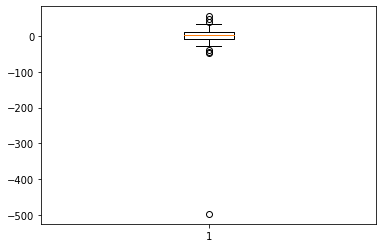

In [10]:
plot_X0=pd.DataFrame(masked_X).assign(trials= lambda x: x.index+1)
plot_X=pd.concat([plot_X0.loc[:,'trials'],plot_X0.iloc[:,1]],axis=1)\
.melt(id_vars='trials').rename(columns={'variable':'voxel','value':'beta'})

plt.boxplot(plot_X.beta)

In [41]:
def outlier_check(data,dectect_type='box'):
    if dectect_type=='box':
        beta_75=np.percentile(data,75)
        beta_25=np.percentile(data,25)
        beta_iqr=(beta_75-beta_25)*1.5    
        lower_limit=beta_25-beta_iqr
        upper_limit=beta_75+beta_iqr
    elif dectect_type[-2:]=='sd':
        beta_mean=np.mean(data)
        beta_std=np.std(data)
        multip_n=float(dectect_type[:-2])
        lower_limit=beta_mean-beta_std*multip_n
        upper_limit=beta_mean+beta_std*multip_n
    outliers_cond=(data<lower_limit)|(data>upper_limit)
    outlierdat=data[outliers_cond]
    return outlierdat

In [52]:
a=set()
for k in outlier_check(plot_X.beta,'box'):
    a.add(k)
a

{-496.7642822265625,
 -47.4896354675293,
 -44.1215934753418,
 -39.20035171508789,
 39.71518325805664,
 48.82206726074219,
 55.18787384033203}

In [55]:
masked_X.shape

(240, 1269928)

In [57]:
a=set()
a.add(2)

In [56]:
box_out=set()
sd_out=set()
for i in tqdm(range(masked_X.shape[1])):
    plot_X0=pd.DataFrame(masked_X).assign(trials= lambda x: x.index+1)
    plot_X=pd.concat([plot_X0.loc[:,'trials'],plot_X0.iloc[:,i]],axis=1)\
    .melt(id_vars='trials').rename(columns={'variable':'voxel','value':'beta'})
    if tria
    for k in outlier_check(plot_X.beta,'box'):
        box_out.add(k)
    for k2 in outlier_check(plot_X.beta,'3sd'):
        sd_out.add(k2)
        


  0%|          | 199/1269928 [03:33<377:41:43,  1.07s/it]


KeyboardInterrupt: 

In [4]:
# Autocorrelation check
for i in range(masked_X.shape[0]):
    print('autocorrelation : '+str(pd.Series(masked_X[i,:]).autocorr()))

autocorrelation : 0.44678293525686114
autocorrelation : 0.485407118405754
autocorrelation : 0.3546105577334271
autocorrelation : 0.31694387960000253
autocorrelation : 0.3788436773431876
autocorrelation : 0.33398591815409234
autocorrelation : 0.3437065578350653
autocorrelation : 0.36118885369667614
autocorrelation : 0.3588715822789736
autocorrelation : 0.5015646550007965
autocorrelation : 0.45889103355826466
autocorrelation : 0.4567839866655772
autocorrelation : 0.49399952459299235
autocorrelation : 0.48177190091697497
autocorrelation : 0.4229366633076772
autocorrelation : 0.4684638079877561
autocorrelation : 0.45477596759243166
autocorrelation : 0.4961386370119416
autocorrelation : 0.43478479044738494
autocorrelation : 0.4317418343637889
autocorrelation : 0.5085281485504312
autocorrelation : 0.5537962542769598
autocorrelation : 0.5094895921932129
autocorrelation : 0.48427745707400244
autocorrelation : 0.4290310364963247
autocorrelation : 0.4542722968192085
autocorrelation : 0.372011081

autocorrelation : 0.3992859041076102
autocorrelation : 0.4588488722648125
autocorrelation : 0.5042430691225704
autocorrelation : 0.18920684163289722
autocorrelation : 0.5424213315477462
autocorrelation : 0.40998293937611047
autocorrelation : 0.4932803603922165
autocorrelation : 0.41896082636125664
autocorrelation : 0.48794488859055507
autocorrelation : 0.12046450720686586
autocorrelation : 0.4032676583373125
autocorrelation : 0.46603708025194207
autocorrelation : 0.4744621023350907
autocorrelation : 0.2548389661744306
autocorrelation : 0.28827563282924745
autocorrelation : -0.07087173046017249
autocorrelation : 0.3934119604698575
autocorrelation : 0.15090516328195344
autocorrelation : 0.15947162080112068
autocorrelation : 0.03293816540912372


In [146]:
grouprun = np.array([0,0,0,0]*10)
a=np.concatenate(([grouprun+i for i in range(6)]),axis=0)
b=np.delete(a,206)
b.shape

(239,)

In [3]:
def group_set(set_type,outlier_del=False):
    group0 = np.array([0,1,0,1]*10)
    group00 = np.array([0,1,2,3]*10)
    grouprun = np.array([0,0,0,0]*10)
    LORO_group = np.concatenate(([group0+2*i for i in range(6)]),axis=0)
    Half_group = np.tile([0,1],120)
    LORO2_group = np.concatenate(([group00+4*i for i in range(6)]),axis=0)
    LOROFull_group = np.concatenate(([grouprun+i for i in range(6)]),axis=0)
    
    if outlier_del:
        LORO_group = np.delete(LORO_group,206)
        Half_group = np.delete(Half_group,206)
        LORO2_group = np.delete(LORO2_group,206)
        LOROFull_group = np.delete(LOROFull_group,206)
    
    if (set_type=='bi_LORO')|(set_type=='same_LORO'):
        test_group=LORO_group
    elif set_type=='Half':
        test_group=Half_group
    elif (set_type=='bi_LORO2')|(set_type=='same_LORO2'):
        test_group=LORO2_group
    elif set_type=='full_LORO':
        test_group=LOROFull_group
    return test_group

# leave 1 run out setting + hand (train:100 ->  test:20)
def LORO_set(group, group_n,test_hand='same'):
    if test_hand=='same':
        train_index = np.where((group!=group_n)&(np.mod(group,2)!=np.mod(group_n,2)))[0]
    else:
        train_index = np.where((group!=2*np.divmod(group_n,2)[0]+1-np.divmod(group_n,2)[1])&(np.mod(group,2)!=np.mod(group_n,2)))[0] 
    test_index = np.where(group==group_n)[0]
    return train_index,test_index

# leave 1 run out setting(+hand, position) (train:50 ->  test:10)
def LORO2_set(group, group_n,test_hand='same'):
    if test_hand=='same':
        train_index = np.where((group!=group_n)&(np.mod(group,4)==np.mod(group_n,4)))[0]
    else:
        train_index = np.where((group!=4*np.divmod(group_n,4)[0]+3-np.divmod(group_n,4)[1])&(np.mod(group,4)==3-np.mod(group_n,4)))[0] 
    test_index = np.where(group==group_n)[0]
    return train_index,test_index

# leave 1 run out setting(not hand) (train:200 ->  test:40)
def LOROfull_set(group, group_n):
    train_index = np.where(group!=group_n)[0]
    test_index = np.where(group==group_n)[0]
    return train_index,test_index

# only hand(train:120 ->  test:120)
def Half_set(group, group_n): 
    train_index = np.where(group!=group_n)[0] 
    test_index = np.where(group==group_n)[0]
    return train_index,test_index


def train_test_set(group,group_n,set_type='Half'):
    if set_type=='bi_LORO':
        train_index, test_index=LORO_set(group, group_n,'bi')
    elif set_type=='same_LORO':
        train_index, test_index=LORO_set(group, group_n,'same')
    elif set_type=='Half':
        train_index, test_index=Half_set(group, group_n)
    elif set_type=='bi_LORO2':
        train_index, test_index=LORO2_set(group, group_n,'bi')
    elif set_type=='same_LORO2':
        train_index, test_index=LORO2_set(group, group_n,'same')
    elif set_type=='full_LORO':
        train_index, test_index=LOROfull_set(group, group_n)
    return train_index,test_index


# check train,test set
train_index, test_index = train_test_set(group_set('bi_LORO2'),0, 'bi_LORO2')
print(len(train_index))
print(len(test_index))

50
10


In [113]:
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
for test_type in ['bi_LORO','same_LORO','bi_LORO2','same_LORO2','full_LORO', 'Half']:
    test_group=group_set(test_type)
    train_n, test_n = train_test_set(test_group,0, test_type)
    for subj in tqdm(subj_list,desc=f'{test_type}_SVC_Whole_loop',position=0,leave=True):
        X, y, group = get_XYG_IF(subj, list(range(1,7)),'mapping')
        cf_y=(y>=np.median(y)).astype('int')
#         mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
        mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/mask.WholeBrain.nii.gz'
        mask_img = nilearn.image.load_img(mask_dir)
        masked_X = fast_masking(X, mask_img)
        y_dat=[]
        y_pred=np.zeros(y.shape)
        acc_dat=[]
        svcs=[]
        svc=LinearSVC(random_state=777,max_iter=1e3)
        for group_n in np.unique(test_group):
            train_index, test_index = train_test_set(test_group,group_n, test_type)
            xtrain = masked_X[train_index,:]
            xtest = masked_X[test_index,:]   ## Ntrials by Nvoxels
            ytrain = cf_y[train_index]       ## Ntrials by 1
            ytest = cf_y[test_index]
            svc.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
            predictions = svc.predict(scale(xtest))
            svcs.append(svc)
            y_pred[test_index]=predictions
            acc0=accuracy_score(predictions,ytest)
            acc_dat.append(acc0)
        mean_acc=np.mean(acc_dat)
        acc_value=accuracy_score(cf_y,y_pred)
        print(f'{subj}_WholeBrain_{test_type}_SVC_accuracy_: {acc_value}_mean_ACC : {mean_acc}')
        
    df=pd.DataFrame({'Subject':subjs,
                     'test_types':test_types,
                     'accuracy':acc_value,
                     'mean_ACC':mean_acc,
                     'y_dat':y_dats,
                     'pred_dat':pred_dats,
                     'svclists':svcs})
    df.to_csv('IF_SVC/wholeBrain'+test_type+'_SVC.csv')

bi_LORO_SVC_Whole_loop:   8%|▊         | 1/12 [06:02<1:06:22, 362.02s/it]

IFE02_WholeBrain_bi_LORO_SVC_accuracy_: 0.5791666666666667_mean_ACC : 0.5791666666666667


bi_LORO_SVC_Whole_loop:  17%|█▋        | 2/12 [12:07<1:00:29, 362.99s/it]

IFL02_WholeBrain_bi_LORO_SVC_accuracy_: 0.5916666666666667_mean_ACC : 0.5916666666666667


bi_LORO_SVC_Whole_loop:  25%|██▌       | 3/12 [17:19<52:09, 347.74s/it]  

IFE03_WholeBrain_bi_LORO_SVC_accuracy_: 0.5458333333333333_mean_ACC : 0.5458333333333334


bi_LORO_SVC_Whole_loop:  33%|███▎      | 4/12 [22:10<44:04, 330.62s/it]

IFL03_WholeBrain_bi_LORO_SVC_accuracy_: 0.5541666666666667_mean_ACC : 0.5541666666666666


bi_LORO_SVC_Whole_loop:  42%|████▏     | 5/12 [26:39<36:26, 312.38s/it]

IFE05_WholeBrain_bi_LORO_SVC_accuracy_: 0.5416666666666666_mean_ACC : 0.5416666666666666


bi_LORO_SVC_Whole_loop:  50%|█████     | 6/12 [31:10<29:59, 299.98s/it]

IFL05_WholeBrain_bi_LORO_SVC_accuracy_: 0.5583333333333333_mean_ACC : 0.5583333333333333


bi_LORO_SVC_Whole_loop:  58%|█████▊    | 7/12 [41:24<32:50, 394.03s/it]

IFE06_WholeBrain_bi_LORO_SVC_accuracy_: 0.5416666666666666_mean_ACC : 0.5416666666666666


bi_LORO_SVC_Whole_loop:  67%|██████▋   | 8/12 [46:05<24:01, 360.25s/it]

IFL06_WholeBrain_bi_LORO_SVC_accuracy_: 0.5291666666666667_mean_ACC : 0.5291666666666667


bi_LORO_SVC_Whole_loop:  75%|███████▌  | 9/12 [51:59<17:54, 358.19s/it]

IFE07_WholeBrain_bi_LORO_SVC_accuracy_: 0.6_mean_ACC : 0.6


bi_LORO_SVC_Whole_loop:  83%|████████▎ | 10/12 [57:13<11:30, 345.11s/it]

IFL07_WholeBrain_bi_LORO_SVC_accuracy_: 0.575_mean_ACC : 0.575


bi_LORO_SVC_Whole_loop:  92%|█████████▏| 11/12 [1:02:06<05:29, 329.44s/it]

IFE08_WholeBrain_bi_LORO_SVC_accuracy_: 0.5833333333333334_mean_ACC : 0.5833333333333334


same_LORO_SVC_Whole_loop:   0%|          | 0/12 [00:00<?, ?it/s]

IFL08_WholeBrain_bi_LORO_SVC_accuracy_: 0.5708333333333333_mean_ACC : 0.5708333333333333


same_LORO_SVC_Whole_loop:   8%|▊         | 1/12 [05:54<1:05:04, 354.95s/it]

IFE02_WholeBrain_same_LORO_SVC_accuracy_: 0.5708333333333333_mean_ACC : 0.5708333333333333


same_LORO_SVC_Whole_loop:  17%|█▋        | 2/12 [11:35<58:27, 350.74s/it]  

IFL02_WholeBrain_same_LORO_SVC_accuracy_: 0.5458333333333333_mean_ACC : 0.5458333333333333


same_LORO_SVC_Whole_loop:  25%|██▌       | 3/12 [16:49<50:56, 339.61s/it]

IFE03_WholeBrain_same_LORO_SVC_accuracy_: 0.49583333333333335_mean_ACC : 0.49583333333333335


same_LORO_SVC_Whole_loop:  33%|███▎      | 4/12 [22:41<45:47, 343.41s/it]

IFL03_WholeBrain_same_LORO_SVC_accuracy_: 0.5208333333333334_mean_ACC : 0.5208333333333334


same_LORO_SVC_Whole_loop:  42%|████▏     | 5/12 [28:06<39:25, 337.92s/it]

IFE05_WholeBrain_same_LORO_SVC_accuracy_: 0.5708333333333333_mean_ACC : 0.5708333333333334


same_LORO_SVC_Whole_loop:  50%|█████     | 6/12 [33:14<32:52, 328.70s/it]

IFL05_WholeBrain_same_LORO_SVC_accuracy_: 0.5125_mean_ACC : 0.5125000000000001


same_LORO_SVC_Whole_loop:  58%|█████▊    | 7/12 [42:26<32:58, 395.73s/it]

IFE06_WholeBrain_same_LORO_SVC_accuracy_: 0.5625_mean_ACC : 0.5625000000000001


same_LORO_SVC_Whole_loop:  67%|██████▋   | 8/12 [47:21<24:21, 365.46s/it]

IFL06_WholeBrain_same_LORO_SVC_accuracy_: 0.475_mean_ACC : 0.4749999999999999


same_LORO_SVC_Whole_loop:  75%|███████▌  | 9/12 [54:21<19:05, 381.85s/it]

IFE07_WholeBrain_same_LORO_SVC_accuracy_: 0.5083333333333333_mean_ACC : 0.5083333333333333


same_LORO_SVC_Whole_loop:  83%|████████▎ | 10/12 [59:28<11:58, 359.42s/it]

IFL07_WholeBrain_same_LORO_SVC_accuracy_: 0.5_mean_ACC : 0.49999999999999994


same_LORO_SVC_Whole_loop:  92%|█████████▏| 11/12 [1:04:42<05:46, 346.03s/it]

IFE08_WholeBrain_same_LORO_SVC_accuracy_: 0.5583333333333333_mean_ACC : 0.5583333333333332


bi_LORO2_SVC_Whole_loop:   0%|          | 0/12 [00:00<?, ?it/s]

IFL08_WholeBrain_same_LORO_SVC_accuracy_: 0.5291666666666667_mean_ACC : 0.5291666666666667


bi_LORO2_SVC_Whole_loop:   8%|▊         | 1/12 [04:57<54:31, 297.41s/it]

IFE02_WholeBrain_bi_LORO2_SVC_accuracy_: 0.5583333333333333_mean_ACC : 0.5583333333333332


bi_LORO2_SVC_Whole_loop:  17%|█▋        | 2/12 [10:07<50:13, 301.36s/it]

IFL02_WholeBrain_bi_LORO2_SVC_accuracy_: 0.5375_mean_ACC : 0.5375


bi_LORO2_SVC_Whole_loop:  25%|██▌       | 3/12 [14:02<42:12, 281.34s/it]

IFE03_WholeBrain_bi_LORO2_SVC_accuracy_: 0.48333333333333334_mean_ACC : 0.48333333333333334


bi_LORO2_SVC_Whole_loop:  33%|███▎      | 4/12 [18:35<37:11, 278.92s/it]

IFL03_WholeBrain_bi_LORO2_SVC_accuracy_: 0.48333333333333334_mean_ACC : 0.4833333333333334


bi_LORO2_SVC_Whole_loop:  42%|████▏     | 5/12 [23:18<32:39, 279.90s/it]

IFE05_WholeBrain_bi_LORO2_SVC_accuracy_: 0.55_mean_ACC : 0.5499999999999999


bi_LORO2_SVC_Whole_loop:  50%|█████     | 6/12 [27:24<26:59, 269.92s/it]

IFL05_WholeBrain_bi_LORO2_SVC_accuracy_: 0.5083333333333333_mean_ACC : 0.5083333333333333


bi_LORO2_SVC_Whole_loop:  50%|█████     | 6/12 [29:18<29:18, 293.00s/it]


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [ ]:
X, y, group = get_XYG_IF(subj, list(range(1,7)),'hit')

In [24]:
for i in range(1,7):
    test=load_Beta_IF_1s('IFL02', i)
    test2=test.get_fdata()
    print(np.isnan(test2).sum())

0
0
0
0
0
8530021


200

In [29]:
# fanROI test
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
for test_type in ['full_LORO']:
    test_group=group_set(test_type)
    train_n, test_n = train_test_set(test_group,0, test_type)
    for subj in tqdm(subj_list,desc=f'{test_type}_SVC_ROI_loop',position=0,leave=True):
        X, y, group = get_XYG_IF_1s(subj, list(range(1,7)),'mapping')
        rois=[]
        acc_values=[]
        y_dats=[]
        pred_dats=[]
        svclist=[]
        for ROI_n in tqdm(range(1,280-3),desc=f'{subj}_SVC_ROI_loop',position=0,leave=True):
            mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
            mask_img = nilearn.image.load_img(mask_dir)
            masked_X = fast_masking(X, mask_img)
            y_dat=[]
            y_pred=np.zeros(y.shape)
            svcs=[]
            svc=LinearSVC(random_state=777,max_iter=5e4)
            for group_n in np.unique(test_group):
                train_index, test_index = train_test_set(test_group,group_n, test_type)
                xtrain = masked_X[train_index,:]
                xtest = masked_X[test_index,:]   ## Ntrials by Nvoxels
                ytrain = y[train_index]       ## Ntrials by 1
                ytest = y[test_index]
                try:
                    svc.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
                    predictions = svc.predict(scale(xtest))
                except:
                    print(subj,ROI_n,test_index[0])
                    continue
                svcs.append(svc)
                y_pred[test_index]=predictions
            acc_value=accuracy_score(y,y_pred)
            rois.append(ROI_n)
            acc_values.append(acc_value)
            y_dats.append(y)
            pred_dats.append(y_pred)
            svclist.append(svcs)
    #         print(f'{subj}_FanROI_{ROI_n}_{test_type}_PCR_{len(train_n)}_r_value_: {r_value}')
        df=pd.DataFrame({'ROI_n':rois,
                         'accuracy':acc_values,
                         'y_dat':y_dats,
                         'pred_dat':pred_dats,
                         'svclists':svclist})
        df.to_csv('IF_SVC/'+subj+'_'+test_type+'_SVC_mapping_scale_1s.csv')

IFL02_SVC_ROI_loop:   0%|          | 0/276 [00:00<?, ?it/s]9, 480.90s/it]

IFL02 1 0
IFL02 1 40
IFL02 1 80
IFL02 1 120
IFL02 1 160


IFL02_SVC_ROI_loop:   0%|          | 1/276 [00:05<24:36,  5.37s/it]

IFL02 1 200
IFL02 2 0
IFL02 2 40
IFL02 2 80
IFL02 2 120
IFL02 2 160


IFL02_SVC_ROI_loop:   1%|          | 2/276 [00:06<18:43,  4.10s/it]

IFL02 2 200
IFL02 3 0
IFL02 3 40
IFL02 3 80
IFL02 3 120
IFL02 3 160


IFL02_SVC_ROI_loop:   1%|          | 3/276 [00:07<14:14,  3.13s/it]

IFL02 3 200
IFL02 4 0
IFL02 4 40
IFL02 4 80
IFL02 4 120
IFL02 4 160


IFL02_SVC_ROI_loop:   1%|▏         | 4/276 [00:08<11:01,  2.43s/it]

IFL02 4 200
IFL02 5 0
IFL02 5 40
IFL02 5 80
IFL02 5 120
IFL02 5 160


IFL02_SVC_ROI_loop:   2%|▏         | 5/276 [00:09<08:59,  1.99s/it]

IFL02 5 200
IFL02 6 0
IFL02 6 40
IFL02 6 80
IFL02 6 120
IFL02 6 160


IFL02_SVC_ROI_loop:   2%|▏         | 6/276 [00:10<07:34,  1.68s/it]

IFL02 6 200
IFL02 7 0
IFL02 7 40
IFL02 7 80
IFL02 7 120
IFL02 7 160


IFL02_SVC_ROI_loop:   3%|▎         | 7/276 [00:10<06:14,  1.39s/it]

IFL02 7 200
IFL02 8 0
IFL02 8 40
IFL02 8 80
IFL02 8 120
IFL02 8 160


IFL02_SVC_ROI_loop:   3%|▎         | 8/276 [00:11<05:21,  1.20s/it]

IFL02 8 200
IFL02 9 0
IFL02 9 40
IFL02 9 80
IFL02 9 120
IFL02 9 160


IFL02_SVC_ROI_loop:   3%|▎         | 9/276 [00:12<05:16,  1.18s/it]

IFL02 9 200
IFL02 10 0
IFL02 10 40
IFL02 10 80
IFL02 10 120
IFL02 10 160


IFL02_SVC_ROI_loop:   4%|▎         | 10/276 [00:13<05:15,  1.19s/it]

IFL02 10 200
IFL02 11 0
IFL02 11 40
IFL02 11 80
IFL02 11 120
IFL02 11 160


IFL02_SVC_ROI_loop:   4%|▍         | 11/276 [00:15<05:09,  1.17s/it]

IFL02 11 200
IFL02 12 0
IFL02 12 40
IFL02 12 80
IFL02 12 120
IFL02 12 160


IFL02_SVC_ROI_loop:   4%|▍         | 12/276 [00:15<04:44,  1.08s/it]

IFL02 12 200
IFL02 13 0
IFL02 13 40
IFL02 13 80
IFL02 13 120
IFL02 13 160


IFL02_SVC_ROI_loop:   5%|▍         | 13/276 [00:16<04:33,  1.04s/it]

IFL02 13 200
IFL02 14 0
IFL02 14 40
IFL02 14 80
IFL02 14 120
IFL02 14 160


IFL02_SVC_ROI_loop:   5%|▌         | 14/276 [00:17<04:23,  1.01s/it]

IFL02 14 200
IFL02 15 0
IFL02 15 40
IFL02 15 80
IFL02 15 120
IFL02 15 160


IFL02_SVC_ROI_loop:   5%|▌         | 15/276 [00:18<04:23,  1.01s/it]

IFL02 15 200
IFL02 16 0
IFL02 16 40
IFL02 16 80
IFL02 16 120
IFL02 16 160


IFL02_SVC_ROI_loop:   6%|▌         | 16/276 [00:19<04:21,  1.01s/it]

IFL02 16 200
IFL02 17 0
IFL02 17 40
IFL02 17 80
IFL02 17 120
IFL02 17 160


IFL02_SVC_ROI_loop:   6%|▌         | 17/276 [00:20<04:04,  1.06it/s]

IFL02 17 200
IFL02 18 0
IFL02 18 40
IFL02 18 80
IFL02 18 120
IFL02 18 160


IFL02_SVC_ROI_loop:   7%|▋         | 18/276 [00:21<03:49,  1.12it/s]

IFL02 18 200
IFL02 19 0
IFL02 19 40
IFL02 19 80
IFL02 19 120
IFL02 19 160


IFL02_SVC_ROI_loop:   7%|▋         | 19/276 [00:22<04:12,  1.02it/s]

IFL02 19 200
IFL02 20 0
IFL02 20 40
IFL02 20 80
IFL02 20 120
IFL02 20 160


IFL02_SVC_ROI_loop:   7%|▋         | 20/276 [00:23<04:07,  1.03it/s]

IFL02 20 200
IFL02 21 0
IFL02 21 40
IFL02 21 80
IFL02 21 120
IFL02 21 160


IFL02_SVC_ROI_loop:   8%|▊         | 21/276 [00:24<04:18,  1.01s/it]

IFL02 21 200
IFL02 22 0
IFL02 22 40
IFL02 22 80
IFL02 22 120
IFL02 22 160


IFL02_SVC_ROI_loop:   8%|▊         | 22/276 [00:25<04:13,  1.00it/s]

IFL02 22 200
IFL02 23 0
IFL02 23 40
IFL02 23 80
IFL02 23 120
IFL02 23 160


IFL02_SVC_ROI_loop:   8%|▊         | 23/276 [00:26<04:05,  1.03it/s]

IFL02 23 200
IFL02 24 0
IFL02 24 40
IFL02 24 80
IFL02 24 120
IFL02 24 160


IFL02_SVC_ROI_loop:   9%|▊         | 24/276 [00:27<03:59,  1.05it/s]

IFL02 24 200
IFL02 25 0
IFL02 25 40
IFL02 25 80
IFL02 25 120
IFL02 25 160


IFL02_SVC_ROI_loop:   9%|▉         | 25/276 [00:28<03:43,  1.12it/s]

IFL02 25 200
IFL02 26 0
IFL02 26 40
IFL02 26 80
IFL02 26 120
IFL02 26 160


IFL02_SVC_ROI_loop:   9%|▉         | 26/276 [00:29<03:47,  1.10it/s]

IFL02 26 200
IFL02 27 0
IFL02 27 40
IFL02 27 80
IFL02 27 120
IFL02 27 160


IFL02_SVC_ROI_loop:  10%|▉         | 27/276 [00:29<03:39,  1.13it/s]

IFL02 27 200
IFL02 28 0
IFL02 28 40
IFL02 28 80
IFL02 28 120
IFL02 28 160


IFL02_SVC_ROI_loop:  10%|█         | 28/276 [00:30<03:47,  1.09it/s]

IFL02 28 200


IFL02_SVC_ROI_loop:  11%|█         | 29/276 [00:31<03:19,  1.24it/s]

IFL02 29 0
IFL02 29 40
IFL02 29 80
IFL02 29 120
IFL02 29 160
IFL02 29 200


IFL02_SVC_ROI_loop:  11%|█         | 30/276 [00:32<03:01,  1.36it/s]

IFL02 30 0
IFL02 30 40
IFL02 30 80
IFL02 30 120
IFL02 30 160
IFL02 30 200


IFL02_SVC_ROI_loop:  11%|█         | 31/276 [00:32<03:04,  1.33it/s]

IFL02 31 0
IFL02 31 40
IFL02 31 80
IFL02 31 120
IFL02 31 160
IFL02 31 200


IFL02_SVC_ROI_loop:  12%|█▏        | 32/276 [00:33<03:05,  1.31it/s]

IFL02 32 0
IFL02 32 40
IFL02 32 80
IFL02 32 120
IFL02 32 160
IFL02 32 200
IFL02 33 0
IFL02 33 40
IFL02 33 80
IFL02 33 120
IFL02 33 160


IFL02_SVC_ROI_loop:  12%|█▏        | 33/276 [00:34<02:56,  1.38it/s]

IFL02 33 200


IFL02_SVC_ROI_loop:  12%|█▏        | 34/276 [00:34<02:48,  1.44it/s]

IFL02 34 0
IFL02 34 40
IFL02 34 80
IFL02 34 120
IFL02 34 160
IFL02 34 200


IFL02_SVC_ROI_loop:  13%|█▎        | 35/276 [00:35<02:43,  1.47it/s]

IFL02 35 0
IFL02 35 40
IFL02 35 80
IFL02 35 120
IFL02 35 160
IFL02 35 200


IFL02_SVC_ROI_loop:  13%|█▎        | 36/276 [00:36<02:40,  1.50it/s]

IFL02 36 0
IFL02 36 40
IFL02 36 80
IFL02 36 120
IFL02 36 160
IFL02 36 200
IFL02 37 0
IFL02 37 40
IFL02 37 80
IFL02 37 120
IFL02 37 160


IFL02_SVC_ROI_loop:  13%|█▎        | 37/276 [00:36<02:43,  1.46it/s]

IFL02 37 200
IFL02 38 0
IFL02 38 40
IFL02 38 80
IFL02 38 120
IFL02 38 160


IFL02_SVC_ROI_loop:  14%|█▍        | 38/276 [00:37<02:43,  1.45it/s]

IFL02 38 200


IFL02_SVC_ROI_loop:  14%|█▍        | 39/276 [00:38<02:33,  1.54it/s]

IFL02 39 0
IFL02 39 40
IFL02 39 80
IFL02 39 120
IFL02 39 160
IFL02 39 200


IFL02_SVC_ROI_loop:  14%|█▍        | 40/276 [00:38<02:27,  1.61it/s]

IFL02 40 0
IFL02 40 40
IFL02 40 80
IFL02 40 120
IFL02 40 160
IFL02 40 200
IFL02 41 0
IFL02 41 40
IFL02 41 80
IFL02 41 120
IFL02 41 160


IFL02_SVC_ROI_loop:  15%|█▍        | 41/276 [00:39<02:32,  1.54it/s]

IFL02 41 200
IFL02 42 0
IFL02 42 40
IFL02 42 80
IFL02 42 120
IFL02 42 160


IFL02_SVC_ROI_loop:  15%|█▌        | 42/276 [00:40<02:40,  1.46it/s]

IFL02 42 200
IFL02 43 0
IFL02 43 40
IFL02 43 80
IFL02 43 120
IFL02 43 160


IFL02_SVC_ROI_loop:  16%|█▌        | 43/276 [00:40<02:42,  1.44it/s]

IFL02 43 200
IFL02 44 0
IFL02 44 40
IFL02 44 80
IFL02 44 120
IFL02 44 160


IFL02_SVC_ROI_loop:  16%|█▌        | 44/276 [00:41<02:42,  1.43it/s]

IFL02 44 200
IFL02 45 0
IFL02 45 40
IFL02 45 80
IFL02 45 120
IFL02 45 160


IFL02_SVC_ROI_loop:  16%|█▋        | 45/276 [00:42<02:50,  1.35it/s]

IFL02 45 200
IFL02 46 0
IFL02 46 40
IFL02 46 80
IFL02 46 120
IFL02 46 160


IFL02_SVC_ROI_loop:  17%|█▋        | 46/276 [00:43<03:04,  1.25it/s]

IFL02 46 200
IFL02 47 0
IFL02 47 40
IFL02 47 80
IFL02 47 120
IFL02 47 160


IFL02_SVC_ROI_loop:  17%|█▋        | 47/276 [00:44<02:57,  1.29it/s]

IFL02 47 200
IFL02 48 0
IFL02 48 40
IFL02 48 80
IFL02 48 120
IFL02 48 160


IFL02_SVC_ROI_loop:  17%|█▋        | 48/276 [00:44<02:54,  1.31it/s]

IFL02 48 200
IFL02 49 0
IFL02 49 40
IFL02 49 80
IFL02 49 120
IFL02 49 160


IFL02_SVC_ROI_loop:  18%|█▊        | 49/276 [00:45<02:54,  1.30it/s]

IFL02 49 200
IFL02 50 0
IFL02 50 40
IFL02 50 80
IFL02 50 120
IFL02 50 160


IFL02_SVC_ROI_loop:  18%|█▊        | 50/276 [00:46<02:48,  1.34it/s]

IFL02 50 200
IFL02 51 0
IFL02 51 40
IFL02 51 80
IFL02 51 120
IFL02 51 160


IFL02_SVC_ROI_loop:  18%|█▊        | 51/276 [00:47<02:54,  1.29it/s]

IFL02 51 200
IFL02 52 0
IFL02 52 40
IFL02 52 80
IFL02 52 120
IFL02 52 160


IFL02_SVC_ROI_loop:  19%|█▉        | 52/276 [00:47<02:46,  1.34it/s]

IFL02 52 200
IFL02 53 0
IFL02 53 40
IFL02 53 80
IFL02 53 120
IFL02 53 160


IFL02_SVC_ROI_loop:  19%|█▉        | 53/276 [00:48<03:00,  1.23it/s]

IFL02 53 200
IFL02 54 0
IFL02 54 40
IFL02 54 80
IFL02 54 120
IFL02 54 160


IFL02_SVC_ROI_loop:  20%|█▉        | 54/276 [00:49<02:53,  1.28it/s]

IFL02 54 200
IFL02 55 0
IFL02 55 40
IFL02 55 80
IFL02 55 120
IFL02 55 160


IFL02_SVC_ROI_loop:  20%|█▉        | 55/276 [00:50<02:50,  1.29it/s]

IFL02 55 200
IFL02 56 0
IFL02 56 40
IFL02 56 80
IFL02 56 120
IFL02 56 160


IFL02_SVC_ROI_loop:  20%|██        | 56/276 [00:51<02:57,  1.24it/s]

IFL02 56 200
IFL02 57 0
IFL02 57 40
IFL02 57 80
IFL02 57 120
IFL02 57 160


IFL02_SVC_ROI_loop:  21%|██        | 57/276 [00:52<03:36,  1.01it/s]

IFL02 57 200
IFL02 58 0
IFL02 58 40
IFL02 58 80
IFL02 58 120
IFL02 58 160


IFL02_SVC_ROI_loop:  21%|██        | 58/276 [00:53<03:22,  1.08it/s]

IFL02 58 200


IFL02_SVC_ROI_loop:  21%|██▏       | 59/276 [00:53<03:01,  1.19it/s]

IFL02 59 0
IFL02 59 40
IFL02 59 80
IFL02 59 120
IFL02 59 160
IFL02 59 200
IFL02 60 0
IFL02 60 40
IFL02 60 80
IFL02 60 120
IFL02 60 160


IFL02_SVC_ROI_loop:  22%|██▏       | 60/276 [00:54<02:53,  1.25it/s]

IFL02 60 200


IFL02_SVC_ROI_loop:  22%|██▏       | 61/276 [00:55<02:42,  1.32it/s]

IFL02 61 0
IFL02 61 40
IFL02 61 80
IFL02 61 120
IFL02 61 160
IFL02 61 200


IFL02_SVC_ROI_loop:  22%|██▏       | 62/276 [00:55<02:34,  1.39it/s]

IFL02 62 0
IFL02 62 40
IFL02 62 80
IFL02 62 120
IFL02 62 160
IFL02 62 200
IFL02 63 0
IFL02 63 40
IFL02 63 80
IFL02 63 120
IFL02 63 160


IFL02_SVC_ROI_loop:  23%|██▎       | 63/276 [00:56<02:39,  1.33it/s]

IFL02 63 200
IFL02 64 0
IFL02 64 40
IFL02 64 80
IFL02 64 120
IFL02 64 160


IFL02_SVC_ROI_loop:  23%|██▎       | 64/276 [00:57<02:38,  1.34it/s]

IFL02 64 200


IFL02_SVC_ROI_loop:  24%|██▎       | 65/276 [00:58<02:27,  1.43it/s]

IFL02 65 0
IFL02 65 40
IFL02 65 80
IFL02 65 120
IFL02 65 160
IFL02 65 200
IFL02 66 0
IFL02 66 40
IFL02 66 80
IFL02 66 120
IFL02 66 160


IFL02_SVC_ROI_loop:  24%|██▍       | 66/276 [00:58<02:29,  1.41it/s]

IFL02 66 200
IFL02 67 0
IFL02 67 40
IFL02 67 80
IFL02 67 120
IFL02 67 160


IFL02_SVC_ROI_loop:  24%|██▍       | 67/276 [00:59<02:26,  1.42it/s]

IFL02 67 200
IFL02 68 0
IFL02 68 40
IFL02 68 80
IFL02 68 120
IFL02 68 160


IFL02_SVC_ROI_loop:  25%|██▍       | 68/276 [01:00<02:34,  1.35it/s]

IFL02 68 200
IFL02 69 0
IFL02 69 40
IFL02 69 80
IFL02 69 120
IFL02 69 160


IFL02_SVC_ROI_loop:  25%|██▌       | 69/276 [01:01<02:30,  1.38it/s]

IFL02 69 200
IFL02 70 0
IFL02 70 40
IFL02 70 80
IFL02 70 120
IFL02 70 160


IFL02_SVC_ROI_loop:  25%|██▌       | 70/276 [01:01<02:31,  1.36it/s]

IFL02 70 200
IFL02 71 0
IFL02 71 40
IFL02 71 80
IFL02 71 120
IFL02 71 160


IFL02_SVC_ROI_loop:  26%|██▌       | 71/276 [01:02<02:42,  1.26it/s]

IFL02 71 200


IFL02_SVC_ROI_loop:  26%|██▌       | 72/276 [01:03<02:30,  1.35it/s]

IFL02 72 0
IFL02 72 40
IFL02 72 80
IFL02 72 120
IFL02 72 160
IFL02 72 200
IFL02 73 0
IFL02 73 40
IFL02 73 80
IFL02 73 120
IFL02 73 160


IFL02_SVC_ROI_loop:  26%|██▋       | 73/276 [01:04<02:54,  1.17it/s]

IFL02 73 200
IFL02 74 0
IFL02 74 40
IFL02 74 80
IFL02 74 120
IFL02 74 160


IFL02_SVC_ROI_loop:  27%|██▋       | 74/276 [01:05<02:45,  1.22it/s]

IFL02 74 200
IFL02 75 0
IFL02 75 40
IFL02 75 80
IFL02 75 120
IFL02 75 160


IFL02_SVC_ROI_loop:  27%|██▋       | 75/276 [01:05<02:35,  1.29it/s]

IFL02 75 200
IFL02 76 0
IFL02 76 40
IFL02 76 80
IFL02 76 120
IFL02 76 160


IFL02_SVC_ROI_loop:  28%|██▊       | 76/276 [01:06<02:33,  1.31it/s]

IFL02 76 200
IFL02 77 0
IFL02 77 40
IFL02 77 80
IFL02 77 120
IFL02 77 160


IFL02_SVC_ROI_loop:  28%|██▊       | 77/276 [01:07<02:37,  1.26it/s]

IFL02 77 200
IFL02 78 0
IFL02 78 40
IFL02 78 80
IFL02 78 120
IFL02 78 160


IFL02_SVC_ROI_loop:  28%|██▊       | 78/276 [01:08<02:33,  1.29it/s]

IFL02 78 200
IFL02 79 0
IFL02 79 40
IFL02 79 80
IFL02 79 120
IFL02 79 160


IFL02_SVC_ROI_loop:  29%|██▊       | 79/276 [01:08<02:30,  1.31it/s]

IFL02 79 200


IFL02_SVC_ROI_loop:  29%|██▉       | 80/276 [01:09<02:21,  1.39it/s]

IFL02 80 0
IFL02 80 40
IFL02 80 80
IFL02 80 120
IFL02 80 160
IFL02 80 200
IFL02 81 0
IFL02 81 40
IFL02 81 80
IFL02 81 120
IFL02 81 160


IFL02_SVC_ROI_loop:  29%|██▉       | 81/276 [01:09<02:01,  1.61it/s]

IFL02 81 200
IFL02 82 0
IFL02 82 40
IFL02 82 80
IFL02 82 120
IFL02 82 160


IFL02_SVC_ROI_loop:  30%|██▉       | 82/276 [01:10<02:03,  1.57it/s]

IFL02 82 200
IFL02 83 0
IFL02 83 40
IFL02 83 80
IFL02 83 120
IFL02 83 160


IFL02_SVC_ROI_loop:  30%|███       | 83/276 [01:11<02:12,  1.46it/s]

IFL02 83 200
IFL02 84 0
IFL02 84 40
IFL02 84 80
IFL02 84 120
IFL02 84 160


IFL02_SVC_ROI_loop:  30%|███       | 84/276 [01:12<02:20,  1.37it/s]

IFL02 84 200
IFL02 85 0
IFL02 85 40
IFL02 85 80
IFL02 85 120
IFL02 85 160


IFL02_SVC_ROI_loop:  31%|███       | 85/276 [01:13<02:20,  1.36it/s]

IFL02 85 200
IFL02 86 0
IFL02 86 40
IFL02 86 80
IFL02 86 120
IFL02 86 160


IFL02_SVC_ROI_loop:  31%|███       | 86/276 [01:13<02:23,  1.32it/s]

IFL02 86 200
IFL02 87 0
IFL02 87 40
IFL02 87 80
IFL02 87 120
IFL02 87 160


IFL02_SVC_ROI_loop:  32%|███▏      | 87/276 [01:14<02:27,  1.28it/s]

IFL02 87 200
IFL02 88 0
IFL02 88 40
IFL02 88 80
IFL02 88 120
IFL02 88 160


IFL02_SVC_ROI_loop:  32%|███▏      | 88/276 [01:16<03:12,  1.02s/it]

IFL02 88 200


IFL02_SVC_ROI_loop:  32%|███▏      | 89/276 [01:16<02:44,  1.14it/s]

IFL02 89 0
IFL02 89 40
IFL02 89 80
IFL02 89 120
IFL02 89 160
IFL02 89 200


IFL02_SVC_ROI_loop:  33%|███▎      | 90/276 [01:17<02:26,  1.27it/s]

IFL02 90 0
IFL02 90 40
IFL02 90 80
IFL02 90 120
IFL02 90 160
IFL02 90 200


IFL02_SVC_ROI_loop:  33%|███▎      | 91/276 [01:17<02:13,  1.39it/s]

IFL02 91 0
IFL02 91 40
IFL02 91 80
IFL02 91 120
IFL02 91 160
IFL02 91 200


IFL02_SVC_ROI_loop:  33%|███▎      | 92/276 [01:18<02:02,  1.50it/s]

IFL02 92 0
IFL02 92 40
IFL02 92 80
IFL02 92 120
IFL02 92 160
IFL02 92 200
IFL02 93 0
IFL02 93 40
IFL02 93 80
IFL02 93 120
IFL02 93 160


IFL02_SVC_ROI_loop:  34%|███▎      | 93/276 [01:19<02:02,  1.49it/s]

IFL02 93 200
IFL02 94 0
IFL02 94 40
IFL02 94 80
IFL02 94 120
IFL02 94 160


IFL02_SVC_ROI_loop:  34%|███▍      | 94/276 [01:19<02:01,  1.50it/s]

IFL02 94 200


IFL02_SVC_ROI_loop:  34%|███▍      | 95/276 [01:20<01:59,  1.51it/s]

IFL02 95 0
IFL02 95 40
IFL02 95 80
IFL02 95 120
IFL02 95 160
IFL02 95 200


IFL02_SVC_ROI_loop:  35%|███▍      | 96/276 [01:21<01:55,  1.56it/s]

IFL02 96 0
IFL02 96 40
IFL02 96 80
IFL02 96 120
IFL02 96 160
IFL02 96 200
IFL02 97 0
IFL02 97 40
IFL02 97 80
IFL02 97 120
IFL02 97 160


IFL02_SVC_ROI_loop:  35%|███▌      | 97/276 [01:21<01:59,  1.50it/s]

IFL02 97 200
IFL02 98 0
IFL02 98 40
IFL02 98 80
IFL02 98 120
IFL02 98 160


IFL02_SVC_ROI_loop:  36%|███▌      | 98/276 [01:22<01:58,  1.50it/s]

IFL02 98 200
IFL02 99 0
IFL02 99 40
IFL02 99 80
IFL02 99 120
IFL02 99 160


IFL02_SVC_ROI_loop:  36%|███▌      | 99/276 [01:23<01:59,  1.48it/s]

IFL02 99 200
IFL02 100 0
IFL02 100 40
IFL02 100 80
IFL02 100 120
IFL02 100 160


IFL02_SVC_ROI_loop:  36%|███▌      | 100/276 [01:23<01:57,  1.49it/s]

IFL02 100 200
IFL02 101 0
IFL02 101 40
IFL02 101 80
IFL02 101 120
IFL02 101 160


IFL02_SVC_ROI_loop:  37%|███▋      | 101/276 [01:24<01:58,  1.48it/s]

IFL02 101 200
IFL02 102 0
IFL02 102 40
IFL02 102 80
IFL02 102 120
IFL02 102 160


IFL02_SVC_ROI_loop:  37%|███▋      | 102/276 [01:25<02:09,  1.35it/s]

IFL02 102 200
IFL02 103 0
IFL02 103 40
IFL02 103 80
IFL02 103 120
IFL02 103 160


IFL02_SVC_ROI_loop:  37%|███▋      | 103/276 [01:26<02:18,  1.25it/s]

IFL02 103 200
IFL02 104 0
IFL02 104 40
IFL02 104 80
IFL02 104 120
IFL02 104 160


IFL02_SVC_ROI_loop:  38%|███▊      | 104/276 [01:28<03:28,  1.21s/it]

IFL02 104 200
IFL02 105 0
IFL02 105 40
IFL02 105 80
IFL02 105 120
IFL02 105 160


IFL02_SVC_ROI_loop:  38%|███▊      | 105/276 [01:29<03:05,  1.09s/it]

IFL02 105 200
IFL02 106 0
IFL02 106 40
IFL02 106 80
IFL02 106 120
IFL02 106 160


IFL02_SVC_ROI_loop:  38%|███▊      | 106/276 [01:30<03:03,  1.08s/it]

IFL02 106 200
IFL02 107 0
IFL02 107 40
IFL02 107 80
IFL02 107 120
IFL02 107 160


IFL02_SVC_ROI_loop:  39%|███▉      | 107/276 [01:32<03:34,  1.27s/it]

IFL02 107 200
IFL02 108 0
IFL02 108 40
IFL02 108 80
IFL02 108 120
IFL02 108 160


IFL02_SVC_ROI_loop:  39%|███▉      | 108/276 [01:33<03:28,  1.24s/it]

IFL02 108 200


IFL02_SVC_ROI_loop:  39%|███▉      | 109/276 [01:33<02:50,  1.02s/it]

IFL02 109 0
IFL02 109 40
IFL02 109 80
IFL02 109 120
IFL02 109 160
IFL02 109 200


IFL02_SVC_ROI_loop:  40%|███▉      | 110/276 [01:34<02:24,  1.15it/s]

IFL02 110 0
IFL02 110 40
IFL02 110 80
IFL02 110 120
IFL02 110 160
IFL02 110 200


IFL02_SVC_ROI_loop:  40%|████      | 111/276 [01:34<02:05,  1.32it/s]

IFL02 111 0
IFL02 111 40
IFL02 111 80
IFL02 111 120
IFL02 111 160
IFL02 111 200


IFL02_SVC_ROI_loop:  41%|████      | 112/276 [01:35<01:51,  1.47it/s]

IFL02 112 0
IFL02 112 40
IFL02 112 80
IFL02 112 120
IFL02 112 160
IFL02 112 200


IFL02_SVC_ROI_loop:  41%|████      | 113/276 [01:35<01:41,  1.61it/s]

IFL02 113 0
IFL02 113 40
IFL02 113 80
IFL02 113 120
IFL02 113 160
IFL02 113 200


IFL02_SVC_ROI_loop:  41%|████▏     | 114/276 [01:36<01:34,  1.71it/s]

IFL02 114 0
IFL02 114 40
IFL02 114 80
IFL02 114 120
IFL02 114 160
IFL02 114 200


IFL02_SVC_ROI_loop:  42%|████▏     | 115/276 [01:36<01:31,  1.77it/s]

IFL02 115 0
IFL02 115 40
IFL02 115 80
IFL02 115 120
IFL02 115 160
IFL02 115 200


IFL02_SVC_ROI_loop:  42%|████▏     | 116/276 [01:37<01:26,  1.84it/s]

IFL02 116 0
IFL02 116 40
IFL02 116 80
IFL02 116 120
IFL02 116 160
IFL02 116 200


IFL02_SVC_ROI_loop:  42%|████▏     | 117/276 [01:37<01:26,  1.85it/s]

IFL02 117 0
IFL02 117 40
IFL02 117 80
IFL02 117 120
IFL02 117 160
IFL02 117 200


IFL02_SVC_ROI_loop:  43%|████▎     | 118/276 [01:38<01:23,  1.89it/s]

IFL02 118 0
IFL02 118 40
IFL02 118 80
IFL02 118 120
IFL02 118 160
IFL02 118 200


IFL02_SVC_ROI_loop:  43%|████▎     | 119/276 [01:38<01:23,  1.88it/s]

IFL02 119 0
IFL02 119 40
IFL02 119 80
IFL02 119 120
IFL02 119 160
IFL02 119 200


IFL02_SVC_ROI_loop:  43%|████▎     | 120/276 [01:39<01:23,  1.87it/s]

IFL02 120 0
IFL02 120 40
IFL02 120 80
IFL02 120 120
IFL02 120 160
IFL02 120 200


IFL02_SVC_ROI_loop:  44%|████▍     | 121/276 [01:39<01:26,  1.79it/s]

IFL02 121 0
IFL02 121 40
IFL02 121 80
IFL02 121 120
IFL02 121 160
IFL02 121 200


IFL02_SVC_ROI_loop:  44%|████▍     | 122/276 [01:40<01:29,  1.72it/s]

IFL02 122 0
IFL02 122 40
IFL02 122 80
IFL02 122 120
IFL02 122 160
IFL02 122 200


IFL02_SVC_ROI_loop:  45%|████▍     | 123/276 [01:41<01:29,  1.72it/s]

IFL02 123 0
IFL02 123 40
IFL02 123 80
IFL02 123 120
IFL02 123 160
IFL02 123 200


IFL02_SVC_ROI_loop:  45%|████▍     | 124/276 [01:41<01:27,  1.73it/s]

IFL02 124 0
IFL02 124 40
IFL02 124 80
IFL02 124 120
IFL02 124 160
IFL02 124 200


IFL02_SVC_ROI_loop:  45%|████▌     | 125/276 [01:42<01:30,  1.66it/s]

IFL02 125 0
IFL02 125 40
IFL02 125 80
IFL02 125 120
IFL02 125 160
IFL02 125 200
IFL02 126 0
IFL02 126 40
IFL02 126 80
IFL02 126 120
IFL02 126 160


IFL02_SVC_ROI_loop:  46%|████▌     | 126/276 [01:43<01:39,  1.51it/s]

IFL02 126 200
IFL02 127 0
IFL02 127 40
IFL02 127 80
IFL02 127 120
IFL02 127 160


IFL02_SVC_ROI_loop:  46%|████▌     | 127/276 [01:43<01:42,  1.45it/s]

IFL02 127 200
IFL02 128 0
IFL02 128 40
IFL02 128 80
IFL02 128 120
IFL02 128 160


IFL02_SVC_ROI_loop:  46%|████▋     | 128/276 [01:44<01:43,  1.42it/s]

IFL02 128 200
IFL02 129 0
IFL02 129 40
IFL02 129 80
IFL02 129 120
IFL02 129 160


IFL02_SVC_ROI_loop:  47%|████▋     | 129/276 [01:45<01:43,  1.41it/s]

IFL02 129 200


IFL02_SVC_ROI_loop:  47%|████▋     | 130/276 [01:46<01:37,  1.49it/s]

IFL02 130 0
IFL02 130 40
IFL02 130 80
IFL02 130 120
IFL02 130 160
IFL02 130 200
IFL02 131 0
IFL02 131 40
IFL02 131 80
IFL02 131 120
IFL02 131 160


IFL02_SVC_ROI_loop:  47%|████▋     | 131/276 [01:46<01:42,  1.42it/s]

IFL02 131 200
IFL02 132 0
IFL02 132 40
IFL02 132 80
IFL02 132 120
IFL02 132 160


IFL02_SVC_ROI_loop:  48%|████▊     | 132/276 [01:47<01:46,  1.36it/s]

IFL02 132 200


IFL02_SVC_ROI_loop:  48%|████▊     | 133/276 [01:48<01:41,  1.41it/s]

IFL02 133 0
IFL02 133 40
IFL02 133 80
IFL02 133 120
IFL02 133 160
IFL02 133 200
IFL02 134 0
IFL02 134 40
IFL02 134 80
IFL02 134 120
IFL02 134 160


IFL02_SVC_ROI_loop:  49%|████▊     | 134/276 [01:48<01:39,  1.43it/s]

IFL02 134 200
IFL02 135 0
IFL02 135 40
IFL02 135 80
IFL02 135 120
IFL02 135 160


IFL02_SVC_ROI_loop:  49%|████▉     | 135/276 [01:49<01:46,  1.32it/s]

IFL02 135 200
IFL02 136 0
IFL02 136 40
IFL02 136 80
IFL02 136 120
IFL02 136 160


IFL02_SVC_ROI_loop:  49%|████▉     | 136/276 [01:51<02:25,  1.04s/it]

IFL02 136 200
IFL02 137 0
IFL02 137 40
IFL02 137 80
IFL02 137 120
IFL02 137 160


IFL02_SVC_ROI_loop:  50%|████▉     | 137/276 [01:52<02:29,  1.08s/it]

IFL02 137 200
IFL02 138 0
IFL02 138 40
IFL02 138 80
IFL02 138 120
IFL02 138 160


IFL02_SVC_ROI_loop:  50%|█████     | 138/276 [01:53<02:30,  1.09s/it]

IFL02 138 200
IFL02 139 0
IFL02 139 40
IFL02 139 80
IFL02 139 120
IFL02 139 160


IFL02_SVC_ROI_loop:  50%|█████     | 139/276 [01:54<02:31,  1.10s/it]

IFL02 139 200
IFL02 140 0
IFL02 140 40
IFL02 140 80
IFL02 140 120
IFL02 140 160


IFL02_SVC_ROI_loop:  51%|█████     | 140/276 [01:55<02:21,  1.04s/it]

IFL02 140 200
IFL02 141 0
IFL02 141 40
IFL02 141 80
IFL02 141 120
IFL02 141 160


IFL02_SVC_ROI_loop:  51%|█████     | 141/276 [01:56<02:20,  1.04s/it]

IFL02 141 200
IFL02 142 0
IFL02 142 40
IFL02 142 80
IFL02 142 120
IFL02 142 160


IFL02_SVC_ROI_loop:  51%|█████▏    | 142/276 [01:58<02:45,  1.24s/it]

IFL02 142 200
IFL02 143 0
IFL02 143 40
IFL02 143 80
IFL02 143 120
IFL02 143 160


IFL02_SVC_ROI_loop:  52%|█████▏    | 143/276 [01:59<02:43,  1.23s/it]

IFL02 143 200
IFL02 144 0
IFL02 144 40
IFL02 144 80
IFL02 144 120
IFL02 144 160


IFL02_SVC_ROI_loop:  52%|█████▏    | 144/276 [02:00<02:30,  1.14s/it]

IFL02 144 200
IFL02 145 0
IFL02 145 40
IFL02 145 80
IFL02 145 120
IFL02 145 160


IFL02_SVC_ROI_loop:  53%|█████▎    | 145/276 [02:01<02:18,  1.05s/it]

IFL02 145 200
IFL02 146 0
IFL02 146 40
IFL02 146 80
IFL02 146 120
IFL02 146 160


IFL02_SVC_ROI_loop:  53%|█████▎    | 146/276 [02:03<02:42,  1.25s/it]

IFL02 146 200
IFL02 147 0
IFL02 147 40
IFL02 147 80
IFL02 147 120
IFL02 147 160


IFL02_SVC_ROI_loop:  53%|█████▎    | 147/276 [02:04<02:23,  1.11s/it]

IFL02 147 200
IFL02 148 0
IFL02 148 40
IFL02 148 80
IFL02 148 120
IFL02 148 160


IFL02_SVC_ROI_loop:  54%|█████▎    | 148/276 [02:04<02:06,  1.01it/s]

IFL02 148 200
IFL02 149 0
IFL02 149 40
IFL02 149 80
IFL02 149 120
IFL02 149 160


IFL02_SVC_ROI_loop:  54%|█████▍    | 149/276 [02:05<02:02,  1.04it/s]

IFL02 149 200
IFL02 150 0
IFL02 150 40
IFL02 150 80
IFL02 150 120
IFL02 150 160


IFL02_SVC_ROI_loop:  54%|█████▍    | 150/276 [02:06<01:57,  1.08it/s]

IFL02 150 200
IFL02 151 0
IFL02 151 40
IFL02 151 80
IFL02 151 120
IFL02 151 160


IFL02_SVC_ROI_loop:  55%|█████▍    | 151/276 [02:07<01:51,  1.13it/s]

IFL02 151 200
IFL02 152 0
IFL02 152 40
IFL02 152 80
IFL02 152 120
IFL02 152 160


IFL02_SVC_ROI_loop:  55%|█████▌    | 152/276 [02:08<01:55,  1.08it/s]

IFL02 152 200
IFL02 153 0
IFL02 153 40
IFL02 153 80
IFL02 153 120
IFL02 153 160


IFL02_SVC_ROI_loop:  55%|█████▌    | 153/276 [02:09<01:45,  1.16it/s]

IFL02 153 200
IFL02 154 0
IFL02 154 40
IFL02 154 80
IFL02 154 120
IFL02 154 160


IFL02_SVC_ROI_loop:  56%|█████▌    | 154/276 [02:09<01:43,  1.17it/s]

IFL02 154 200
IFL02 155 0
IFL02 155 40
IFL02 155 80
IFL02 155 120
IFL02 155 160


IFL02_SVC_ROI_loop:  56%|█████▌    | 155/276 [02:10<01:48,  1.11it/s]

IFL02 155 200
IFL02 156 0
IFL02 156 40
IFL02 156 80
IFL02 156 120
IFL02 156 160


IFL02_SVC_ROI_loop:  57%|█████▋    | 156/276 [02:11<01:45,  1.13it/s]

IFL02 156 200
IFL02 157 0
IFL02 157 40
IFL02 157 80
IFL02 157 120
IFL02 157 160


IFL02_SVC_ROI_loop:  57%|█████▋    | 157/276 [02:12<01:37,  1.23it/s]

IFL02 157 200
IFL02 158 0
IFL02 158 40
IFL02 158 80
IFL02 158 120
IFL02 158 160


IFL02_SVC_ROI_loop:  57%|█████▋    | 158/276 [02:13<01:31,  1.29it/s]

IFL02 158 200
IFL02 159 0
IFL02 159 40
IFL02 159 80
IFL02 159 120
IFL02 159 160


IFL02_SVC_ROI_loop:  58%|█████▊    | 159/276 [02:14<01:46,  1.10it/s]

IFL02 159 200
IFL02 160 0
IFL02 160 40
IFL02 160 80
IFL02 160 120
IFL02 160 160


IFL02_SVC_ROI_loop:  58%|█████▊    | 160/276 [02:15<01:49,  1.06it/s]

IFL02 160 200
IFL02 161 0
IFL02 161 40
IFL02 161 80
IFL02 161 120
IFL02 161 160


IFL02_SVC_ROI_loop:  58%|█████▊    | 161/276 [02:16<01:43,  1.11it/s]

IFL02 161 200
IFL02 162 0
IFL02 162 40
IFL02 162 80
IFL02 162 120
IFL02 162 160


IFL02_SVC_ROI_loop:  59%|█████▊    | 162/276 [02:16<01:37,  1.17it/s]

IFL02 162 200


IFL02_SVC_ROI_loop:  59%|█████▉    | 163/276 [02:17<01:27,  1.30it/s]

IFL02 163 0
IFL02 163 40
IFL02 163 80
IFL02 163 120
IFL02 163 160
IFL02 163 200


IFL02_SVC_ROI_loop:  59%|█████▉    | 164/276 [02:18<01:20,  1.39it/s]

IFL02 164 0
IFL02 164 40
IFL02 164 80
IFL02 164 120
IFL02 164 160
IFL02 164 200


IFL02_SVC_ROI_loop:  60%|█████▉    | 165/276 [02:18<01:15,  1.47it/s]

IFL02 165 0
IFL02 165 40
IFL02 165 80
IFL02 165 120
IFL02 165 160
IFL02 165 200


IFL02_SVC_ROI_loop:  60%|██████    | 166/276 [02:19<01:09,  1.58it/s]

IFL02 166 0
IFL02 166 40
IFL02 166 80
IFL02 166 120
IFL02 166 160
IFL02 166 200


IFL02_SVC_ROI_loop:  61%|██████    | 167/276 [02:19<01:08,  1.59it/s]

IFL02 167 0
IFL02 167 40
IFL02 167 80
IFL02 167 120
IFL02 167 160
IFL02 167 200


IFL02_SVC_ROI_loop:  61%|██████    | 168/276 [02:20<01:07,  1.60it/s]

IFL02 168 0
IFL02 168 40
IFL02 168 80
IFL02 168 120
IFL02 168 160
IFL02 168 200


IFL02_SVC_ROI_loop:  61%|██████    | 169/276 [02:21<01:15,  1.42it/s]

IFL02 169 0
IFL02 169 40
IFL02 169 80
IFL02 169 120
IFL02 169 160
IFL02 169 200


IFL02_SVC_ROI_loop:  62%|██████▏   | 170/276 [02:21<01:14,  1.42it/s]

IFL02 170 0
IFL02 170 40
IFL02 170 80
IFL02 170 120
IFL02 170 160
IFL02 170 200


IFL02_SVC_ROI_loop:  62%|██████▏   | 171/276 [02:22<01:09,  1.51it/s]

IFL02 171 0
IFL02 171 40
IFL02 171 80
IFL02 171 120
IFL02 171 160
IFL02 171 200


IFL02_SVC_ROI_loop:  62%|██████▏   | 172/276 [02:23<01:05,  1.58it/s]

IFL02 172 0
IFL02 172 40
IFL02 172 80
IFL02 172 120
IFL02 172 160
IFL02 172 200


IFL02_SVC_ROI_loop:  63%|██████▎   | 173/276 [02:23<01:04,  1.59it/s]

IFL02 173 0
IFL02 173 40
IFL02 173 80
IFL02 173 120
IFL02 173 160
IFL02 173 200


IFL02_SVC_ROI_loop:  63%|██████▎   | 174/276 [02:24<01:03,  1.60it/s]

IFL02 174 0
IFL02 174 40
IFL02 174 80
IFL02 174 120
IFL02 174 160
IFL02 174 200


IFL02_SVC_ROI_loop:  63%|██████▎   | 175/276 [02:24<01:02,  1.61it/s]

IFL02 175 0
IFL02 175 40
IFL02 175 80
IFL02 175 120
IFL02 175 160
IFL02 175 200


IFL02_SVC_ROI_loop:  64%|██████▍   | 176/276 [02:25<01:02,  1.61it/s]

IFL02 176 0
IFL02 176 40
IFL02 176 80
IFL02 176 120
IFL02 176 160
IFL02 176 200


IFL02_SVC_ROI_loop:  64%|██████▍   | 177/276 [02:26<00:59,  1.68it/s]

IFL02 177 0
IFL02 177 40
IFL02 177 80
IFL02 177 120
IFL02 177 160
IFL02 177 200


IFL02_SVC_ROI_loop:  64%|██████▍   | 178/276 [02:26<00:59,  1.65it/s]

IFL02 178 0
IFL02 178 40
IFL02 178 80
IFL02 178 120
IFL02 178 160
IFL02 178 200
IFL02 179 0
IFL02 179 40
IFL02 179 80
IFL02 179 120
IFL02 179 160


IFL02_SVC_ROI_loop:  65%|██████▍   | 179/276 [02:27<01:00,  1.60it/s]

IFL02 179 200


IFL02_SVC_ROI_loop:  65%|██████▌   | 180/276 [02:28<00:59,  1.61it/s]

IFL02 180 0
IFL02 180 40
IFL02 180 80
IFL02 180 120
IFL02 180 160
IFL02 180 200
IFL02 181 0
IFL02 181 40
IFL02 181 80
IFL02 181 120
IFL02 181 160


IFL02_SVC_ROI_loop:  66%|██████▌   | 181/276 [02:28<01:02,  1.52it/s]

IFL02 181 200


IFL02_SVC_ROI_loop:  66%|██████▌   | 182/276 [02:29<01:00,  1.56it/s]

IFL02 182 0
IFL02 182 40
IFL02 182 80
IFL02 182 120
IFL02 182 160
IFL02 182 200


IFL02_SVC_ROI_loop:  66%|██████▋   | 183/276 [02:29<00:58,  1.58it/s]

IFL02 183 0
IFL02 183 40
IFL02 183 80
IFL02 183 120
IFL02 183 160
IFL02 183 200


IFL02_SVC_ROI_loop:  67%|██████▋   | 184/276 [02:30<00:55,  1.65it/s]

IFL02 184 0
IFL02 184 40
IFL02 184 80
IFL02 184 120
IFL02 184 160
IFL02 184 200
IFL02 185 0
IFL02 185 40
IFL02 185 80
IFL02 185 120
IFL02 185 160


IFL02_SVC_ROI_loop:  67%|██████▋   | 185/276 [02:31<01:07,  1.36it/s]

IFL02 185 200
IFL02 186 0
IFL02 186 40
IFL02 186 80
IFL02 186 120
IFL02 186 160


IFL02_SVC_ROI_loop:  67%|██████▋   | 186/276 [02:32<01:09,  1.30it/s]

IFL02 186 200
IFL02 187 0
IFL02 187 40
IFL02 187 80
IFL02 187 120
IFL02 187 160


IFL02_SVC_ROI_loop:  68%|██████▊   | 187/276 [02:33<01:08,  1.29it/s]

IFL02 187 200


IFL02_SVC_ROI_loop:  68%|██████▊   | 188/276 [02:33<01:04,  1.36it/s]

IFL02 188 0
IFL02 188 40
IFL02 188 80
IFL02 188 120
IFL02 188 160
IFL02 188 200


IFL02_SVC_ROI_loop:  68%|██████▊   | 189/276 [02:34<01:01,  1.41it/s]

IFL02 189 0
IFL02 189 40
IFL02 189 80
IFL02 189 120
IFL02 189 160
IFL02 189 200
IFL02 190 0
IFL02 190 40
IFL02 190 80
IFL02 190 120
IFL02 190 160


IFL02_SVC_ROI_loop:  69%|██████▉   | 190/276 [02:35<01:01,  1.41it/s]

IFL02 190 200
IFL02 191 0
IFL02 191 40
IFL02 191 80
IFL02 191 120
IFL02 191 160


IFL02_SVC_ROI_loop:  69%|██████▉   | 191/276 [02:35<01:01,  1.38it/s]

IFL02 191 200
IFL02 192 0
IFL02 192 40
IFL02 192 80
IFL02 192 120
IFL02 192 160


IFL02_SVC_ROI_loop:  70%|██████▉   | 192/276 [02:36<01:08,  1.22it/s]

IFL02 192 200
IFL02 193 0
IFL02 193 40
IFL02 193 80
IFL02 193 120
IFL02 193 160


IFL02_SVC_ROI_loop:  70%|██████▉   | 193/276 [02:37<01:10,  1.18it/s]

IFL02 193 200
IFL02 194 0
IFL02 194 40
IFL02 194 80
IFL02 194 120
IFL02 194 160


IFL02_SVC_ROI_loop:  70%|███████   | 194/276 [02:38<01:05,  1.25it/s]

IFL02 194 200
IFL02 195 0
IFL02 195 40
IFL02 195 80
IFL02 195 120
IFL02 195 160


IFL02_SVC_ROI_loop:  71%|███████   | 195/276 [02:39<01:04,  1.26it/s]

IFL02 195 200
IFL02 196 0
IFL02 196 40
IFL02 196 80
IFL02 196 120
IFL02 196 160


IFL02_SVC_ROI_loop:  71%|███████   | 196/276 [02:40<01:12,  1.11it/s]

IFL02 196 200
IFL02 197 0
IFL02 197 40
IFL02 197 80
IFL02 197 120
IFL02 197 160


IFL02_SVC_ROI_loop:  71%|███████▏  | 197/276 [02:41<01:22,  1.04s/it]

IFL02 197 200
IFL02 198 0
IFL02 198 40
IFL02 198 80
IFL02 198 120
IFL02 198 160


IFL02_SVC_ROI_loop:  72%|███████▏  | 198/276 [02:43<01:32,  1.18s/it]

IFL02 198 200
IFL02 199 0
IFL02 199 40
IFL02 199 80
IFL02 199 120
IFL02 199 160


IFL02_SVC_ROI_loop:  72%|███████▏  | 199/276 [02:44<01:27,  1.13s/it]

IFL02 199 200
IFL02 200 0
IFL02 200 40
IFL02 200 80
IFL02 200 120
IFL02 200 160


IFL02_SVC_ROI_loop:  72%|███████▏  | 200/276 [02:45<01:24,  1.11s/it]

IFL02 200 200
IFL02 201 0
IFL02 201 40
IFL02 201 80
IFL02 201 120
IFL02 201 160


IFL02_SVC_ROI_loop:  73%|███████▎  | 201/276 [02:46<01:22,  1.09s/it]

IFL02 201 200
IFL02 202 0
IFL02 202 40
IFL02 202 80
IFL02 202 120
IFL02 202 160


IFL02_SVC_ROI_loop:  73%|███████▎  | 202/276 [02:47<01:13,  1.01it/s]

IFL02 202 200
IFL02 203 0
IFL02 203 40
IFL02 203 80
IFL02 203 120
IFL02 203 160


IFL02_SVC_ROI_loop:  74%|███████▎  | 203/276 [02:48<01:23,  1.14s/it]

IFL02 203 200
IFL02 204 0
IFL02 204 40
IFL02 204 80
IFL02 204 120
IFL02 204 160


IFL02_SVC_ROI_loop:  74%|███████▍  | 204/276 [02:50<01:26,  1.21s/it]

IFL02 204 200
IFL02 205 0
IFL02 205 40
IFL02 205 80
IFL02 205 120
IFL02 205 160


IFL02_SVC_ROI_loop:  74%|███████▍  | 205/276 [02:51<01:30,  1.27s/it]

IFL02 205 200
IFL02 206 0
IFL02 206 40
IFL02 206 80
IFL02 206 120
IFL02 206 160


IFL02_SVC_ROI_loop:  75%|███████▍  | 206/276 [02:52<01:21,  1.16s/it]

IFL02 206 200
IFL02 207 0
IFL02 207 40
IFL02 207 80
IFL02 207 120
IFL02 207 160


IFL02_SVC_ROI_loop:  75%|███████▌  | 207/276 [02:53<01:15,  1.09s/it]

IFL02 207 200
IFL02 208 0
IFL02 208 40
IFL02 208 80
IFL02 208 120
IFL02 208 160


IFL02_SVC_ROI_loop:  75%|███████▌  | 208/276 [02:54<01:06,  1.02it/s]

IFL02 208 200
IFL02 209 0
IFL02 209 40
IFL02 209 80
IFL02 209 120
IFL02 209 160


IFL02_SVC_ROI_loop:  76%|███████▌  | 209/276 [02:54<01:00,  1.10it/s]

IFL02 209 200
IFL02 210 0
IFL02 210 40
IFL02 210 80
IFL02 210 120
IFL02 210 160


IFL02_SVC_ROI_loop:  76%|███████▌  | 210/276 [02:55<00:57,  1.15it/s]

IFL02 210 200


IFL02_SVC_ROI_loop:  76%|███████▋  | 211/276 [02:56<00:49,  1.32it/s]

IFL02 211 0
IFL02 211 40
IFL02 211 80
IFL02 211 120
IFL02 211 160
IFL02 211 200


IFL02_SVC_ROI_loop:  77%|███████▋  | 212/276 [02:56<00:44,  1.45it/s]

IFL02 212 0
IFL02 212 40
IFL02 212 80
IFL02 212 120
IFL02 212 160
IFL02 212 200


IFL02_SVC_ROI_loop:  77%|███████▋  | 213/276 [02:57<00:39,  1.60it/s]

IFL02 213 0
IFL02 213 40
IFL02 213 80
IFL02 213 120
IFL02 213 160
IFL02 213 200


IFL02_SVC_ROI_loop:  78%|███████▊  | 214/276 [02:57<00:36,  1.70it/s]

IFL02 214 0
IFL02 214 40
IFL02 214 80
IFL02 214 120
IFL02 214 160
IFL02 214 200
IFL02 215 0
IFL02 215 40
IFL02 215 80
IFL02 215 120
IFL02 215 160


IFL02_SVC_ROI_loop:  78%|███████▊  | 215/276 [02:58<00:39,  1.54it/s]

IFL02 215 200


IFL02_SVC_ROI_loop:  78%|███████▊  | 216/276 [02:59<00:38,  1.55it/s]

IFL02 216 0
IFL02 216 40
IFL02 216 80
IFL02 216 120
IFL02 216 160
IFL02 216 200


IFL02_SVC_ROI_loop:  79%|███████▊  | 217/276 [02:59<00:37,  1.56it/s]

IFL02 217 0
IFL02 217 40
IFL02 217 80
IFL02 217 120
IFL02 217 160
IFL02 217 200
IFL02 218 0
IFL02 218 40
IFL02 218 80
IFL02 218 120
IFL02 218 160


IFL02_SVC_ROI_loop:  79%|███████▉  | 218/276 [03:00<00:37,  1.54it/s]

IFL02 218 200


IFL02_SVC_ROI_loop:  79%|███████▉  | 219/276 [03:00<00:36,  1.56it/s]

IFL02 219 0
IFL02 219 40
IFL02 219 80
IFL02 219 120
IFL02 219 160
IFL02 219 200


IFL02_SVC_ROI_loop:  80%|███████▉  | 220/276 [03:01<00:35,  1.59it/s]

IFL02 220 0
IFL02 220 40
IFL02 220 80
IFL02 220 120
IFL02 220 160
IFL02 220 200


IFL02_SVC_ROI_loop:  80%|████████  | 221/276 [03:02<00:41,  1.34it/s]

IFL02 221 0
IFL02 221 40
IFL02 221 80
IFL02 221 120
IFL02 221 160
IFL02 221 200


IFL02_SVC_ROI_loop:  80%|████████  | 222/276 [03:03<00:37,  1.45it/s]

IFL02 222 0
IFL02 222 40
IFL02 222 80
IFL02 222 120
IFL02 222 160
IFL02 222 200


IFL02_SVC_ROI_loop:  81%|████████  | 223/276 [03:03<00:34,  1.54it/s]

IFL02 223 0
IFL02 223 40
IFL02 223 80
IFL02 223 120
IFL02 223 160
IFL02 223 200


IFL02_SVC_ROI_loop:  81%|████████  | 224/276 [03:04<00:32,  1.59it/s]

IFL02 224 0
IFL02 224 40
IFL02 224 80
IFL02 224 120
IFL02 224 160
IFL02 224 200


IFL02_SVC_ROI_loop:  82%|████████▏ | 225/276 [03:04<00:31,  1.62it/s]

IFL02 225 0
IFL02 225 40
IFL02 225 80
IFL02 225 120
IFL02 225 160
IFL02 225 200


IFL02_SVC_ROI_loop:  82%|████████▏ | 226/276 [03:05<00:30,  1.64it/s]

IFL02 226 0
IFL02 226 40
IFL02 226 80
IFL02 226 120
IFL02 226 160
IFL02 226 200


IFL02_SVC_ROI_loop:  82%|████████▏ | 227/276 [03:06<00:30,  1.61it/s]

IFL02 227 0
IFL02 227 40
IFL02 227 80
IFL02 227 120
IFL02 227 160
IFL02 227 200
IFL02 228 0
IFL02 228 40
IFL02 228 80
IFL02 228 120
IFL02 228 160


IFL02_SVC_ROI_loop:  83%|████████▎ | 228/276 [03:06<00:31,  1.55it/s]

IFL02 228 200
IFL02 229 0
IFL02 229 40
IFL02 229 80
IFL02 229 120
IFL02 229 160


IFL02_SVC_ROI_loop:  83%|████████▎ | 229/276 [03:07<00:31,  1.47it/s]

IFL02 229 200


IFL02_SVC_ROI_loop:  83%|████████▎ | 230/276 [03:08<00:36,  1.28it/s]

IFL02 230 0
IFL02 230 40
IFL02 230 80
IFL02 230 120
IFL02 230 160
IFL02 230 200


IFL02_SVC_ROI_loop:  84%|████████▎ | 231/276 [03:09<00:36,  1.24it/s]

IFL02 231 0
IFL02 231 40
IFL02 231 80
IFL02 231 120
IFL02 231 160
IFL02 231 200


IFL02_SVC_ROI_loop:  84%|████████▍ | 232/276 [03:10<00:41,  1.06it/s]

IFL02 232 0
IFL02 232 40
IFL02 232 80
IFL02 232 120
IFL02 232 160
IFL02 232 200


IFL02_SVC_ROI_loop:  84%|████████▍ | 233/276 [03:11<00:35,  1.21it/s]

IFL02 233 0
IFL02 233 40
IFL02 233 80
IFL02 233 120
IFL02 233 160
IFL02 233 200


IFL02_SVC_ROI_loop:  85%|████████▍ | 234/276 [03:12<00:37,  1.13it/s]

IFL02 234 0
IFL02 234 40
IFL02 234 80
IFL02 234 120
IFL02 234 160
IFL02 234 200


IFL02_SVC_ROI_loop:  85%|████████▌ | 235/276 [03:12<00:31,  1.29it/s]

IFL02 235 0
IFL02 235 40
IFL02 235 80
IFL02 235 120
IFL02 235 160
IFL02 235 200


IFL02_SVC_ROI_loop:  86%|████████▌ | 236/276 [03:13<00:28,  1.42it/s]

IFL02 236 0
IFL02 236 40
IFL02 236 80
IFL02 236 120
IFL02 236 160
IFL02 236 200


IFL02_SVC_ROI_loop:  86%|████████▌ | 237/276 [03:13<00:25,  1.52it/s]

IFL02 237 0
IFL02 237 40
IFL02 237 80
IFL02 237 120
IFL02 237 160
IFL02 237 200


IFL02_SVC_ROI_loop:  86%|████████▌ | 238/276 [03:14<00:23,  1.60it/s]

IFL02 238 0
IFL02 238 40
IFL02 238 80
IFL02 238 120
IFL02 238 160
IFL02 238 200


IFL02_SVC_ROI_loop:  87%|████████▋ | 239/276 [03:15<00:22,  1.66it/s]

IFL02 239 0
IFL02 239 40
IFL02 239 80
IFL02 239 120
IFL02 239 160
IFL02 239 200


IFL02_SVC_ROI_loop:  87%|████████▋ | 240/276 [03:15<00:21,  1.67it/s]

IFL02 240 0
IFL02 240 40
IFL02 240 80
IFL02 240 120
IFL02 240 160
IFL02 240 200


IFL02_SVC_ROI_loop:  87%|████████▋ | 241/276 [03:16<00:25,  1.39it/s]

IFL02 241 0
IFL02 241 40
IFL02 241 80
IFL02 241 120
IFL02 241 160
IFL02 241 200


IFL02_SVC_ROI_loop:  88%|████████▊ | 242/276 [03:17<00:30,  1.10it/s]

IFL02 242 0
IFL02 242 40
IFL02 242 80
IFL02 242 120
IFL02 242 160
IFL02 242 200


IFL02_SVC_ROI_loop:  88%|████████▊ | 243/276 [03:18<00:26,  1.24it/s]

IFL02 243 0
IFL02 243 40
IFL02 243 80
IFL02 243 120
IFL02 243 160
IFL02 243 200


IFL02_SVC_ROI_loop:  88%|████████▊ | 244/276 [03:19<00:25,  1.23it/s]

IFL02 244 0
IFL02 244 40
IFL02 244 80
IFL02 244 120
IFL02 244 160
IFL02 244 200


IFL02_SVC_ROI_loop:  89%|████████▉ | 245/276 [03:20<00:24,  1.28it/s]

IFL02 245 0
IFL02 245 40
IFL02 245 80
IFL02 245 120
IFL02 245 160
IFL02 245 200


IFL02_SVC_ROI_loop:  89%|████████▉ | 246/276 [03:20<00:21,  1.41it/s]

IFL02 246 0
IFL02 246 40
IFL02 246 80
IFL02 246 120
IFL02 246 160
IFL02 246 200
IFL02 247 0
IFL02 247 40
IFL02 247 80
IFL02 247 120
IFL02 247 160


IFL02_SVC_ROI_loop:  89%|████████▉ | 247/276 [03:21<00:20,  1.43it/s]

IFL02 247 200
IFL02 248 0
IFL02 248 40
IFL02 248 80
IFL02 248 120
IFL02 248 160


IFL02_SVC_ROI_loop:  90%|████████▉ | 248/276 [03:22<00:23,  1.21it/s]

IFL02 248 200
IFL02 249 0
IFL02 249 40
IFL02 249 80
IFL02 249 120
IFL02 249 160


IFL02_SVC_ROI_loop:  90%|█████████ | 249/276 [03:23<00:22,  1.22it/s]

IFL02 249 200
IFL02 250 0
IFL02 250 40
IFL02 250 80
IFL02 250 120
IFL02 250 160


IFL02_SVC_ROI_loop:  91%|█████████ | 250/276 [03:23<00:20,  1.24it/s]

IFL02 250 200
IFL02 251 0
IFL02 251 40
IFL02 251 80
IFL02 251 120
IFL02 251 160


IFL02_SVC_ROI_loop:  91%|█████████ | 251/276 [03:25<00:22,  1.11it/s]

IFL02 251 200


IFL02_SVC_ROI_loop:  91%|█████████▏| 252/276 [03:25<00:20,  1.18it/s]

IFL02 252 0
IFL02 252 40
IFL02 252 80
IFL02 252 120
IFL02 252 160
IFL02 252 200
IFL02 253 0
IFL02 253 40
IFL02 253 80
IFL02 253 120
IFL02 253 160


IFL02_SVC_ROI_loop:  92%|█████████▏| 253/276 [03:27<00:24,  1.07s/it]

IFL02 253 200
IFL02 254 0
IFL02 254 40
IFL02 254 80
IFL02 254 120
IFL02 254 160


IFL02_SVC_ROI_loop:  92%|█████████▏| 254/276 [03:28<00:26,  1.18s/it]

IFL02 254 200
IFL02 255 0
IFL02 255 40
IFL02 255 80
IFL02 255 120
IFL02 255 160


IFL02_SVC_ROI_loop:  92%|█████████▏| 255/276 [03:32<00:39,  1.90s/it]

IFL02 255 200
IFL02 256 0
IFL02 256 40
IFL02 256 80
IFL02 256 120
IFL02 256 160


IFL02_SVC_ROI_loop:  93%|█████████▎| 256/276 [03:33<00:35,  1.78s/it]

IFL02 256 200


IFL02_SVC_ROI_loop:  93%|█████████▎| 257/276 [03:34<00:29,  1.54s/it]

IFL02 257 0
IFL02 257 40
IFL02 257 80
IFL02 257 120
IFL02 257 160
IFL02 257 200
IFL02 258 0
IFL02 258 40
IFL02 258 80
IFL02 258 120
IFL02 258 160


IFL02_SVC_ROI_loop:  93%|█████████▎| 258/276 [03:37<00:34,  1.92s/it]

IFL02 258 200


IFL02_SVC_ROI_loop:  94%|█████████▍| 259/276 [03:38<00:25,  1.53s/it]

IFL02 259 0
IFL02 259 40
IFL02 259 80
IFL02 259 120
IFL02 259 160
IFL02 259 200


IFL02_SVC_ROI_loop:  94%|█████████▍| 260/276 [03:38<00:19,  1.20s/it]

IFL02 260 0
IFL02 260 40
IFL02 260 80
IFL02 260 120
IFL02 260 160
IFL02 260 200


IFL02_SVC_ROI_loop:  95%|█████████▍| 261/276 [03:39<00:15,  1.03s/it]

IFL02 261 0
IFL02 261 40
IFL02 261 80
IFL02 261 120
IFL02 261 160
IFL02 261 200


IFL02_SVC_ROI_loop:  95%|█████████▍| 262/276 [03:40<00:12,  1.12it/s]

IFL02 262 0
IFL02 262 40
IFL02 262 80
IFL02 262 120
IFL02 262 160
IFL02 262 200


IFL02_SVC_ROI_loop:  95%|█████████▌| 263/276 [03:40<00:11,  1.17it/s]

IFL02 263 0
IFL02 263 40
IFL02 263 80
IFL02 263 120
IFL02 263 160
IFL02 263 200


IFL02_SVC_ROI_loop:  96%|█████████▌| 264/276 [03:41<00:09,  1.30it/s]

IFL02 264 0
IFL02 264 40
IFL02 264 80
IFL02 264 120
IFL02 264 160
IFL02 264 200


IFL02_SVC_ROI_loop:  96%|█████████▌| 265/276 [03:41<00:07,  1.44it/s]

IFL02 265 0
IFL02 265 40
IFL02 265 80
IFL02 265 120
IFL02 265 160
IFL02 265 200


IFL02_SVC_ROI_loop:  96%|█████████▋| 266/276 [03:42<00:06,  1.50it/s]

IFL02 266 0
IFL02 266 40
IFL02 266 80
IFL02 266 120
IFL02 266 160
IFL02 266 200


IFL02_SVC_ROI_loop:  97%|█████████▋| 267/276 [03:43<00:05,  1.53it/s]

IFL02 267 0
IFL02 267 40
IFL02 267 80
IFL02 267 120
IFL02 267 160
IFL02 267 200


IFL02_SVC_ROI_loop:  97%|█████████▋| 268/276 [03:43<00:05,  1.56it/s]

IFL02 268 0
IFL02 268 40
IFL02 268 80
IFL02 268 120
IFL02 268 160
IFL02 268 200


IFL02_SVC_ROI_loop:  97%|█████████▋| 269/276 [03:44<00:04,  1.64it/s]

IFL02 269 0
IFL02 269 40
IFL02 269 80
IFL02 269 120
IFL02 269 160
IFL02 269 200
IFL02 270 0
IFL02 270 40
IFL02 270 80
IFL02 270 120
IFL02 270 160


IFL02_SVC_ROI_loop:  98%|█████████▊| 270/276 [03:44<00:03,  1.53it/s]

IFL02 270 200


IFL02_SVC_ROI_loop:  98%|█████████▊| 271/276 [03:45<00:03,  1.66it/s]

IFL02 271 0
IFL02 271 40
IFL02 271 80
IFL02 271 120
IFL02 271 160
IFL02 271 200


IFL02_SVC_ROI_loop:  99%|█████████▊| 272/276 [03:45<00:02,  1.81it/s]

IFL02 272 0
IFL02 272 40
IFL02 272 80
IFL02 272 120
IFL02 272 160
IFL02 272 200


IFL02_SVC_ROI_loop:  99%|█████████▉| 273/276 [03:46<00:01,  1.67it/s]

IFL02 273 0
IFL02 273 40
IFL02 273 80
IFL02 273 120
IFL02 273 160
IFL02 273 200


IFL02_SVC_ROI_loop:  99%|█████████▉| 274/276 [03:47<00:01,  1.72it/s]

IFL02 274 0
IFL02 274 40
IFL02 274 80
IFL02 274 120
IFL02 274 160
IFL02 274 200
IFL02 275 0
IFL02 275 40
IFL02 275 80
IFL02 275 120
IFL02 275 160


IFL02_SVC_ROI_loop: 100%|█████████▉| 275/276 [03:50<00:01,  1.56s/it]

IFL02 275 200


IFL02_SVC_ROI_loop: 100%|██████████| 276/276 [03:51<00:00,  1.19it/s]

IFL02 276 0
IFL02 276 40
IFL02 276 80
IFL02 276 120
IFL02 276 160
IFL02 276 200



full_LORO_SVC_ROI_loop: 100%|██████████| 12/12 [1:30:30<00:00, 452.53s/it]


In [31]:
# Read output
ROInames=pd.read_csv('fan280_fullname.csv',header=None)
ROInames.iloc[1,0]
def readSVCMapdat(subj_ID,test_type):    
    SVCdata=pd.read_csv(f'IF_SVC/{subj_ID}_{test_type}_SVC_mapping_unscale.csv',
                        index_col=0).assign(ROI_names=lambda x: \
                                            x.ROI_n.apply(lambda x2: \
                                                          ROInames.iloc[x2,0]),
                                            subj=subj_ID[:2]+subj_ID[-2:],Early=subj_ID[2])
    return SVCdata.iloc[:,[-2,-1,-3,1,2]]
def readSVC1sMapdat(subj_ID,test_type):    
    SVCdata=pd.read_csv(f'IF_SVC/{subj_ID}_{test_type}_SVC_mapping_scale_1s.csv',
                        index_col=0).assign(ROI_names=lambda x: \
                                            x.ROI_n.apply(lambda x2: \
                                                          ROInames.iloc[x2,0]),
                                            subj=subj_ID[:2]+subj_ID[-2:],Early=subj_ID[2])
    return SVCdata.iloc[:,[-2,-1,-3,1,2]]

In [18]:
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_types=['full_LORO']
Totaldata=pd.DataFrame(columns={'subj','Early','ROI_names','accuracy','testType'})
for test_type in test_types:
    SVCMapdata=readSVCMapdat(subj_list[0],test_type)
    for i in range(1,len(subj_list)):
        SVCMapdata=pd.concat([SVCMapdata,readSVCMapdat(subj_list[i],test_type)],axis=0)
    Totaldata=pd.concat([Totaldata,SVCMapdata.assign(testType=test_type)],axis=0)
fig=px.scatter(Totaldata,y='accuracy',x='ROI_names',color='Early',facet_col='subj',
           title=f'SVC_fanROI',range_y=[0,1],hover_name='ROI_names',animation_frame='testType')
fig.show()

In [37]:
subj_list = ['IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_types=['full_LORO']
Totaldata=pd.DataFrame(columns={'subj','Early','ROI_names','accuracy','testType'})
for test_type in test_types:
    SVCMapdata=readSVC1sMapdat(subj_list[0],test_type)
    for i in range(1,len(subj_list)):
        SVCMapdata=pd.concat([SVCMapdata,readSVCMapdat(subj_list[i],test_type)],axis=0)
    Totaldata=pd.concat([Totaldata,SVCMapdata.assign(testType=test_type)],axis=0)
fig=px.scatter(Totaldata,y='accuracy',x='ROI_names',color='Early',facet_col='subj',
           title=f'SVC_fanROI',range_y=[0,1],hover_name='ROI_names',animation_frame='testType')
fig.show()
fig.write_html('SVC1s_scatter.html')

In [36]:
grouped_data=Totaldata.groupby(['Early', 'ROI_names'])
plotdat=grouped_data.agg(['mean','sem'])
test1=plotdat.reset_index()
test1.columns=['Early','ROI_names','mean_acc','sem_acc']
fig=px.bar(test1, y='ROI_names',x='mean_acc',error_x='sem_acc',color='Early',barmode='group',hover_name='ROI_names',range_x=[0,0.8])
fig.add_shape(type='line',y0=test1.ROI_names.unique()[0],y1=test1.ROI_names.unique()[-1],
                  x0=0.5,x1=0.5,line=dict(color="Black",width=3,dash="dot"))
fig.update_layout(autosize=True,width=1500,height=6000)
fig.show()
fig.write_html('SVC1s_mapping.html')

In [32]:
grouped_data=Totaldata.groupby(['Early', 'ROI_names'])
plotdat=grouped_data.agg(['mean','sem'])
test1=plotdat.reset_index()
test1.columns=['Early','ROI_names','mean_acc','sem_acc']
fig=px.bar(test1, y='ROI_names',x='mean_acc',error_x='sem_acc',color='Early',barmode='group',hover_name='ROI_names',range_x=[0,0.8])
fig.add_shape(type='line',y0=test1.ROI_names.unique()[0],y1=test1.ROI_names.unique()[-1],
                  x0=0.5,x1=0.5,line=dict(color="Black",width=3,dash="dot"))
fig.update_layout(autosize=True,width=1500,height=6000)
fig.show()

In [34]:
fig.write_html('SVC_mapping.html')

In [ ]:
fig=px.bar(Totaldata, y='ROI_names',x='mean_acc',error_x='sem_acc',color='Early',barmode='group',hover_name='ROI_names',range_x=[0,0.8])
fig.add_shape(type='line',y0=test2.ROI_names.unique()[0],y1=test2.ROI_names.unique()[-1],
                  x0=0.5,x1=0.5,line=dict(color="Black",width=3,dash="dot"))
fig.update_layout(autosize=True,width=1500,height=6000)
fig.show()

In [ ]:
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
for test_type in ['bi_LORO','same_LORO','bi_LORO2','same_LORO2','full_LORO', 'Half']:
    test_group=group_set(test_type)
    train_n, test_n = train_test_set(test_group,0, test_type)
    for subj in tqdm(subj_list,desc=f'PCR_ROI_loop',position=0,leave=True):
        X, y, group = get_XYG_IF(subj, list(range(1,7)),'hit')
        cf_y=(y>=np.median(y))
        mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
#         mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/mask.WholeBrain.nii.gz'
        mask_img = nilearn.image.load_img(mask_dir)
        masked_X = fast_masking(X, mask_img)
        y_dat=[]
        pred_dat=[]
        y_pred=np.zeros(y.shape)
        pcrs=[]
        svc=LinearSVC(random_state=42)
        for group_n in np.unique(test_group):
            train_index, test_index = train_test_set(test_group,group_n, test_type)
            xtrain = masked_X[train_index,:]
            xtest = masked_X[test_index,:]   ## Ntrials by Nvoxels
            ytrain = y[train_index]       ## Ntrials by 1
            ytest = y[test_index]
            pcr.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
            predictions = pcr.predict(scale(xtest))
            pcrs.append(pcr)
            y_pred[test_index]=predictions
        r_value, p_value = stats.pearsonr(y,y_pred)
        print(f'{subj}_FanROI_{ROI_n}_{test_type}_PCR_{len(train_n)}_r_value_: {r_value}')

In [29]:
# fanROI test
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
for test_type in ['bi_LORO','same_LORO','bi_LORO2','same_LORO2''full_LORO', 'Half']:
    test_group=group_set(test_type)
    train_n, test_n = train_test_set(test_group,0, test_type)
    for subj in tqdm(subj_list,desc=f'PCR_ROI_loop',position=0,leave=True):
        X, y, group = get_XYG_IF(subj, list(range(1,7)),'hit')
        rois=[]
        r_values=[]
        p_values=[]
        y_dats=[]
        pred_dats=[]
        pcrlist=[]
        for ROI_n in tqdm(range(1,280-3),desc=f'{subj}_PCR_ROI_loop',position=0,leave=True):
            mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
            # mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan.WholeBrain.nii.gz'
            mask_img = nilearn.image.load_img(mask_dir)
            masked_X = fast_masking(X, mask_img)
            y_dat=[]
            pred_dat=[]
            y_pred=np.zeros(y.shape)
            pcrs=[]
            pcr=PCR(n_components = np.min([len(train_n),masked_X.shape[1]]))
            for group_n in np.unique(test_group):
                train_index, test_index = train_test_set(test_group,group_n, test_type)
                xtrain = masked_X[train_index,:]
                xtest = masked_X[test_index,:]   ## Ntrials by Nvoxels
                ytrain = y[train_index]       ## Ntrials by 1
                ytest = y[test_index]
                pcr.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
                predictions = pcr.predict(scale(xtest))
                pcrs.append(pcr)
                y_pred[test_index]=predictions
            r_value, p_value = stats.pearsonr(y,y_pred)
            rois.append(ROI_n)
            r_values.append(r_value)
            p_values.append(p_value)
            y_dats.append(y)
            pred_dats.append(y_pred)
            pcrlist.append(pcrs)
    #         print(f'{subj}_FanROI_{ROI_n}_{test_type}_PCR_{len(train_n)}_r_value_: {r_value}')
        df=pd.DataFrame({'ROI_n':rois,
                         'r_values':r_values,
                         'p_values':p_values,
                         'y_dat':y_dats,
                         'pred_dat':pred_dats,
                         'pcrlists':pcrlist})
        df.to_csv(subj+'_'+test_type+'_PCR.csv')

IFE03_PCR_ROI_loop:   0%|          | 1/276 [00:05<27:28,  6.00s/it]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:   1%|          | 3/

IFE03_PCR_ROI_loop:  20%|█▉        | 55/276 [00:52<02:47,  1.32it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:  21%|██        | 5

IFE03_PCR_ROI_loop:  46%|████▌     | 127/276 [01:43<01:36,  1.55it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:  47%|████▋     | 

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:  58%|█████▊    | 159/276 [02:13<01:42,  1.14it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python

IFE03_PCR_ROI_loop:  21%|██▏       | 59/276 [00:32<01:35,  2.26it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:  24%|██▎       | 65/276 [00:35<01:33,  2.25it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

IFE03_PCR_ROI_loop:  24%|██▍       | 66/276 [00:35<01:32,  2.27it/s]/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/envs/npy3_Q/lib/python3.7/site-packa

In [5]:
# Read output
ROInames=pd.read_csv('fan280_fullname.csv',header=None)
ROInames.iloc[1,0]
def readSVCdat(subj_ID,test_type):    
    SVCdata=pd.read_csv(f'IF_SVC/{subj_ID}_{test_type}_SVC_unscale.csv',
                        index_col=0).assign(ROI_names=lambda x: \
                                            x.ROI_n.apply(lambda x2: \
                                                          ROInames.iloc[x2,0]),
                                            subj=subj_ID[:2]+subj_ID[-2:],Early=subj_ID[2])
    return SVCdata.iloc[:,[-2,-1,-3,1,2]]

In [156]:
SVCdata0=readSVCdat('IFE02','half')
SVCdata0.head(3)

subj Early                                       ROI_names  accuracy  \
0  IF02     E        Rt. superior frontal gyrus (BA8, medial)  0.579167   
1  IF02     E  Lt. superior frontal gyrus (BA8, dorsolateral)  0.558333   
2  IF02     E  Rt. superior frontal gyrus (BA8, dorsolateral)  0.570833   

   mean_acc  
0  0.579167  
1  0.558333  
2  0.570833

In [161]:
type(Totaldata)

pandas.core.frame.DataFrame

In [160]:
SVCdata.drop(columns={'mean_acc'}).assign(testType=test_type)

subj Early                                       ROI_names  accuracy  \
0    IF02     E        Rt. superior frontal gyrus (BA8, medial)  0.545833   
1    IF02     E  Lt. superior frontal gyrus (BA8, dorsolateral)  0.616667   
2    IF02     E  Rt. superior frontal gyrus (BA8, dorsolateral)  0.558333   
3    IF02     E       Lt. superior frontal gyrus (BA9, lateral)  0.620833   
4    IF02     E       Rt. superior frontal gyrus (BA9, lateral)  0.525000   
..    ...   ...                                             ...       ...   
271  IF08     L                       Rt. cerebellum (lobule X)  0.550000   
272  IF08     L                                    Hypothalamus  0.537500   
273  IF08     L                                       Brainstem  0.512500   
274  IF08     L                             Periaqueductal gray  0.533333   
275  IF08     L                            Lt. substantia nigra  0.520833   

    testType  
0    bi_LORO  
1    bi_LORO  
2    bi_LORO  
3    bi_LORO  
4    bi_LORO  
..       ...  
271  bi_LORO  
272  bi_LORO  
273  bi_LORO  
274  bi_LORO  
275  bi_LORO  

[3312 rows x 5 columns]

In [6]:
# visualize output
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_types=['bi_LORO','same_LORO','full_LORO', 'Half']
Totaldata=pd.DataFrame(columns={'subj','Early','ROI_names','accuracy','testType'})
for test_type in test_types:
    SVCdata=readSVCdat(subj_list[0],test_type)
    for i in range(1,len(subj_list)):
        SVCdata=pd.concat([SVCdata,readSVCdat(subj_list[i],test_type)],axis=0)
    Totaldata=pd.concat([Totaldata,SVCdata.drop(columns={'mean_acc'}).assign(testType=test_type)],axis=0)
fig=px.scatter(Totaldata,y='accuracy',x='ROI_names',color='Early',facet_col='subj',
           title=f'SVC_fanROI',range_y=[0,1],hover_name='ROI_names',animation_frame='testType')
fig.show()

FileNotFoundError: [Errno 2] File IF_SVC/IFE02_bi_LORO_SVC_unscale.csv does not exist: 'IF_SVC/IFE02_bi_LORO_SVC_unscale.csv'

In [ ]:
dataE, dataL = np.zeros((6,280)), np.zeros((6,280))
for m in range(6):
    for n in range(280):
        dataE[m, n] = results[subj_list[2*m], n+1]
        dataL[m, n] = results[subj_list[2*m+1], n+1]
#data_df = pd.DataFrame(data_array, columns = roi_label.values, index= subj_list)
data_dfE = pd.DataFrame(dataE, columns = roi_label.values)
data_dfL = pd.DataFrame(dataL, columns = roi_label.values)
ax = sns.barplot(data=data_dfE, ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
#ax.axhline(0.5, ls='--')
ax.set(ylim=(0.0, 8))
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=data_dfE, ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
#ax.axhline(0.5, ls='--')
ax.set(ylim=(0.0, .8))

In [10]:
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_types=['full_LORO']
Totaldata=pd.DataFrame(columns={'subj','Early','ROI_names','accuracy','testType'})
for test_type in test_types:
    SVCdata=readSVCdat(subj_list[0],test_type)
    for i in range(1,len(subj_list)):
        SVCdata=pd.concat([SVCdata,readSVCdat(subj_list[i],test_type)],axis=0)
    Totaldata=pd.concat([Totaldata,SVCdata.assign(testType=test_type)],axis=0)
fig=px.scatter(Totaldata,y='accuracy',x='ROI_names',color='Early',facet_col='subj',
           title=f'SVC_fanROI',range_y=[0,1],hover_name='ROI_names',animation_frame='testType')
fig.show()

In [441]:
Totaldata.head(3)

Early  accuracy                                       ROI_names  subj  \
0     E  0.570833        Rt. superior frontal gyrus (BA8, medial)  IF02   
1     E  0.612500  Lt. superior frontal gyrus (BA8, dorsolateral)  IF02   
2     E  0.620833  Rt. superior frontal gyrus (BA8, dorsolateral)  IF02   

    testType  
0  full_LORO  
1  full_LORO  
2  full_LORO

In [452]:
grouped_data=Totaldata.groupby(['Early', 'ROI_names'])
plotdat=grouped_data.agg(['mean','sem'])
test1=plotdat.reset_index()
test1

accuracy          
                                                   mean       sem
Early ROI_names                                                  
E     Brainstem                                0.562500  0.024296
      Hypothalamus                             0.538889  0.020516
      Lt. amygdala (lAmyg, lateral amygdala)   0.558333  0.029600
      Lt. amygdala (mAmyg, medial amygdala)    0.632639  0.043320
      Lt. basal ganglia (GP, globus pallidus)  0.583333  0.020441
...                                                 ...       ...
L     Vermis. cerebellum (lobule VI)           0.571528  0.017126
      Vermis. cerebellum (lobule VIIIa)        0.519444  0.014659
      Vermis. cerebellum (lobule VIIIb)        0.529167  0.023472
      Vermis. cerebellum (lobule VIIb)         0.545833  0.015811
      Vermis. cerebellum (lobule X)            0.511111  0.023806

[552 rows x 2 columns]

In [482]:
test1.columns=['Early','ROI_names','mean_acc','sem_acc']

In [502]:
fig=px.bar(test1, y='ROI_names',x='mean_acc',error_x='sem_acc',color='Early',barmode='group',hover_name='ROI_names',range_x=[0,0.8])
fig.add_shape(type='line',y0=test1.ROI_names.unique()[0],y1=test1.ROI_names.unique()[-1],
                  x0=0.5,x1=0.5,line=dict(color="Black",width=3,dash="dot"))
fig.update_layout(autosize=True,width=1500,height=1500)
fig.show()

In [505]:
test2=test1[test1.mean_acc>0.5]

In [511]:
fig=px.bar(test1, y='ROI_names',x='mean_acc',error_x='sem_acc',color='Early',barmode='group',hover_name='ROI_names',range_x=[0,0.8])
fig.add_shape(type='line',y0=test2.ROI_names.unique()[0],y1=test2.ROI_names.unique()[-1],
                  x0=0.5,x1=0.5,line=dict(color="Black",width=3,dash="dot"))
fig.update_layout(autosize=True,width=1500,height=6000)
fig.show()

In [400]:
Totaldata.sort_values('ROI_names')

Early  accuracy                      ROI_names  subj   testType
273     E  0.533333                      Brainstem  IF03    bi_LORO
273     E  0.370833                      Brainstem  IF06  same_LORO
273     E  0.558333                      Brainstem  IF07    bi_LORO
273     L  0.437500                      Brainstem  IF06       Half
273     L  0.512500                      Brainstem  IF08    bi_LORO
..    ...       ...                            ...   ...        ...
270     E  0.587500  Vermis. cerebellum (lobule X)  IF08       Half
270     E  0.545833  Vermis. cerebellum (lobule X)  IF07       Half
270     L  0.504167  Vermis. cerebellum (lobule X)  IF06  same_LORO
270     E  0.458333  Vermis. cerebellum (lobule X)  IF02  same_LORO
270     L  0.487500  Vermis. cerebellum (lobule X)  IF03  full_LORO

[13248 rows x 5 columns]

In [431]:
# visualize output
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_types=['full_LORO']
Totaldata=pd.DataFrame(columns={'subj','Early','ROI_names','accuracy','testType'})
for test_type in test_types:
    SVCdata=readSVCdat(subj_list[0],test_type)
    for i in range(1,len(subj_list)):
        SVCdata=pd.concat([SVCdata,readSVCdat(subj_list[i],test_type)],axis=0)
    Totaldata=pd.concat([Totaldata,SVCdata.drop(columns={'mean_acc'}).assign(testType=test_type)],axis=0)
fig=px.bar(Totaldata,x='accuracy',y='ROI_names',color='Early',facet_col='testType',barmode='group',
           title=f'SVC_fanROI',range_x=[0,1],hover_name='ROI_names',animation_frame='subj')
fig=px.bar(Totaldata,x='accuracy',y='ROI_names',color='Early',facet_col='testType',barmode='group',
           title=f'SVC_fanROI',range_x=[0,1],hover_name='ROI_names',animation_frame='subj')
fig.update_xaxes(title=None)
fig.update_layout(autosize=True,width=1500,height=1500)
fig.show()

In [433]:
fig = make_subplots(rows=1, cols=1, subplot_titles=Totaldata.subj.unique(),
                    x_title='fanROI name',y_title='Accuracy',shared_xaxes=True,shared_yaxes=True)
Totaldata0=Totaldata.sort_values('ROI_names')
dataEarly=Totaldata0[(Totaldata0.subj==Totaldata0.subj.unique()[1-1])&(Totaldata0.testType==Totaldata0.testType.unique()[0])&(Totaldata0.Early=='E')]
dataLate=Totaldata0[(Totaldata0.subj==Totaldata0.subj.unique()[1-1])&(Totaldata0.testType==Totaldata0.testType.unique()[0])&(Totaldata0.Early=='L')]
fig.add_trace(go.Bar(x=dataEarly.ROI_names,y=dataEarly.accuracy,
                    marker_color='red',name='Early',legendgroup='Early'),row=1, col=1)
fig.add_trace(go.Bar(x=dataLate.ROI_names,y=dataLate.accuracy,
                    marker_color='blue',name='Late',legendgroup='Late'),row=1, col=1)
fig.add_shape(type='line',x0=Totaldata0.ROI_names.unique()[0],x1=Totaldata0.ROI_names.unique()[-1],
                  y0=0.5,y1=0.5,line=dict(color="Black",width=3,dash="dot"),row=1, col=1)
fig.update_yaxes(range=[0,1])

In [383]:
def drawSubplot(figure,data,id_n,type_n,legend=False):
    dataEarly=data[(data.subj==data.subj.unique()[id_n-1])&(data.testType==data.testType.unique()[type_n])&(data.Early=='E')]
    dataLate=data[(data.subj==data.subj.unique()[id_n-1])&(data.testType==data.testType.unique()[type_n])&(data.Early=='L')]
    figure.add_trace(go.Bar(x=dataEarly.ROI_names,y=dataEarly.accuracy,
                    marker_color='rgb(0,0,255)',name='Early',legendgroup='Early'),row=1, col=id_n)
    figure.add_trace(go.bar(x=dataLate.ROI_names,y=dataLate.accuracy,
                    marker_color='rgb(255,0,0)',name='Late',legendgroup='Late'),row=1, col=id_n)
    figure.add_shape(type='line',x0=data.ROI_names.unique()[0],x1=data.ROI_names.unique()[-1],
                  y0=0.5,y1=0.5,line=dict(color="Black",width=3,dash="dot"),row=1, col=id_n)
    figure.update_yaxes(range=[0,1])
    figure.update_layout(showlegend=legend,hovermode="x unified")
    return figure

fig = make_subplots(rows=1, cols=6, subplot_titles=Totaldata.subj.unique(),
                    x_title='fanROI name',y_title='Accuracy',shared_xaxes=True,shared_yaxes=True)
for i in range(1,7):
    fig=drawSubplot(fig,Totaldata,i,2,legend=True)
fig.update_layout(title_text=f'SVC_{test_types[0]}')
fig.show()

TypeError: 'module' object is not callable

In [68]:
# Read output
ROInames=pd.read_csv('fan280_fullname.csv',header=None)
ROInames.iloc[1,0]
def readPCRdat(subj_ID,test_type):    
    PCRdata=pd.read_csv(f'{subj_ID}_{test_type}_PCR.csv',
                        index_col=0).assign(ROI_names=lambda x: \
                                            x.ROI_n.apply(lambda x2: \
                                                          ROInames.iloc[x2,0]),
                                            subj=subj_ID[:2]+subj_ID[-2:],Early=subj_ID[2])
    return PCRdata.iloc[:,[-2,-1,-3,1,2]]

In [148]:
PCRdata0=readPCRdat('IFE02','bi_LORO')
PCRdata0

subj Early                                       ROI_names  r_values  \
0    IF02     E        Rt. superior frontal gyrus (BA8, medial) -0.040995   
1    IF02     E  Lt. superior frontal gyrus (BA8, dorsolateral) -0.030879   
2    IF02     E  Rt. superior frontal gyrus (BA8, dorsolateral) -0.011556   
3    IF02     E       Lt. superior frontal gyrus (BA9, lateral) -0.073624   
4    IF02     E       Rt. superior frontal gyrus (BA9, lateral) -0.038717   
..    ...   ...                                             ...       ...   
271  IF02     E                       Rt. cerebellum (lobule X) -0.107186   
272  IF02     E                                    Hypothalamus -0.216420   
273  IF02     E                                       Brainstem -0.168688   
274  IF02     E                             Periaqueductal gray -0.286948   
275  IF02     E                            Lt. substantia nigra -0.166156   

     p_values  
0    0.527357  
1    0.634078  
2    0.858648  
3    0.255888  
4    0.550576  
..        ...  
271  0.097594  
272  0.000737  
273  0.008833  
274  0.000006  
275  0.009920  

[276 rows x 5 columns]

In [164]:
# visualize output
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
test_type='bi_LORO'
PCRdata=readPCRdat(subj_list[0],test_type)
for i in range(1,len(subj_list)):
    PCRdata=pd.concat([PCRdata,readPCRdat(subj_list[i],test_type)],axis=0)
px.scatter(PCRdata,x='ROI_names',y='r_values',color='Early',facet_col='subj')

In [33]:
df_X=pd.DataFrame(masked_X)
px.line(masked_X[:,1])

In [7]:
# Whole brain
subj_list = ['IFE02','IFL02','IFE03','IFL03','IFE05','IFL05','IFE06','IFL06','IFE07','IFL07','IFE08','IFL08']
for test_type in ['bi_LORO','same_LORO','bi_LORO2','same_LORO2','full_LORO', 'Half']:
    test_group=group_set(test_type)
    train_n, test_n = train_test_set(test_group,0, test_type)
    subjs=[]
    r_values=[]
    p_values=[]
    y_dats=[]
    pred_dats=[]
    pcrlist=[]
    test_types=[]
    for subj in tqdm(subj_list,desc=f'PCR_ROI_loop',position=0,leave=True):
        X, y, group = get_XYG_IF(subj, list(range(1,7)),'hit')
#         mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
        mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan.WholeBrain.nii.gz'
        mask_img = nilearn.image.load_img(mask_dir)
        masked_X = fast_masking(X, mask_img)
        y_dat=[]
        pred_dat=[]
        y_pred=np.zeros(y.shape)
        pcrs=[]
        pcr=PCR(n_components = np.min([len(train_n),masked_X.shape[1]]))
        for group_n in np.unique(test_group):
            train_index, test_index = train_test_set(test_group,group_n, test_type)
            xtrain = masked_X[train_index,:]
            xtest = masked_X[test_index,:]   ## Ntrials by Nvoxels
            ytrain = y[train_index]       ## Ntrials by 1
            ytest = y[test_index]
            pcr.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
            predictions = pcr.predict(scale(xtest))
            pcrs.append(pcr)
            y_pred[test_index]=predictions
        r_value, p_value = stats.pearsonr(y,y_pred)
        subjs.append(subj)
        test_types.append(test_type)
        r_values.append(r_value)
        p_values.append(p_value)
        y_dats.append(y)
        pred_dats.append(y_pred)
        pcrlist.append(pcrs)
        print(f'{subj}_wholeBrain_{test_type}_PCR_{len(train_n)}_r_value_: {r_value}')
    df=pd.DataFrame({'Subject':subjs,
                     'test_types':test_types,
                     'r_values':r_values,
                     'p_values':p_values,
                     'y_dat':y_dats,
                     'pred_dat':pred_dats,
                     'pcrlists':pcrlist})
    df.to_csv('wholeBrain'+test_type+'_PCR.csv')


PCR_ROI_loop:   8%|▊         | 1/12 [06:35<1:12:32, 395.64s/it]

IFE02_wholeBrain_bi_LORO_PCR_100_r_value_: -0.14877185508909763


PCR_ROI_loop:  17%|█▋        | 2/12 [12:18<1:03:18, 379.84s/it]

IFL02_wholeBrain_bi_LORO_PCR_100_r_value_: -0.1934724104997446


PCR_ROI_loop:  25%|██▌       | 3/12 [17:37<54:15, 361.69s/it]  

IFE03_wholeBrain_bi_LORO_PCR_100_r_value_: 0.02716131199481677


PCR_ROI_loop:  33%|███▎      | 4/12 [23:51<48:41, 365.19s/it]

IFL03_wholeBrain_bi_LORO_PCR_100_r_value_: -0.2905946500001819


PCR_ROI_loop:  42%|████▏     | 5/12 [29:34<41:49, 358.44s/it]

IFE05_wholeBrain_bi_LORO_PCR_100_r_value_: 0.04637582521332642


PCR_ROI_loop:  50%|█████     | 6/12 [35:19<35:27, 354.57s/it]

IFL05_wholeBrain_bi_LORO_PCR_100_r_value_: -0.2576482979440373


PCR_ROI_loop:  58%|█████▊    | 7/12 [41:08<29:23, 352.78s/it]

IFE06_wholeBrain_bi_LORO_PCR_100_r_value_: -0.742553281616696


PCR_ROI_loop:  67%|██████▋   | 8/12 [47:59<24:40, 370.21s/it]

IFL06_wholeBrain_bi_LORO_PCR_100_r_value_: -0.022237194519530566


PCR_ROI_loop:  75%|███████▌  | 9/12 [55:02<19:18, 386.15s/it]

IFE07_wholeBrain_bi_LORO_PCR_100_r_value_: -0.10828716989954891


PCR_ROI_loop:  83%|████████▎ | 10/12 [1:01:51<13:06, 393.07s/it]

IFL07_wholeBrain_bi_LORO_PCR_100_r_value_: -0.1730963885151641


PCR_ROI_loop:  92%|█████████▏| 11/12 [1:08:45<06:39, 399.23s/it]

IFE08_wholeBrain_bi_LORO_PCR_100_r_value_: 0.2767452620285833


PCR_ROI_loop: 100%|██████████| 12/12 [1:15:31<00:00, 377.62s/it]

IFL08_wholeBrain_bi_LORO_PCR_100_r_value_: 0.23214229538105854



PCR_ROI_loop:   8%|▊         | 1/12 [06:43<1:13:53, 403.02s/it]

IFE02_wholeBrain_same_LORO_PCR_120_r_value_: -0.20369597778969745


PCR_ROI_loop:  17%|█▋        | 2/12 [13:35<1:07:38, 405.81s/it]

IFL02_wholeBrain_same_LORO_PCR_120_r_value_: 0.06035349672925934


PCR_ROI_loop:  25%|██▌       | 3/12 [20:01<59:58, 399.86s/it]  

IFE03_wholeBrain_same_LORO_PCR_120_r_value_: -0.07719372718163527


PCR_ROI_loop:  33%|███▎      | 4/12 [27:04<54:13, 406.72s/it]

IFL03_wholeBrain_same_LORO_PCR_120_r_value_: -0.29812254935539695


PCR_ROI_loop:  42%|████▏     | 5/12 [33:57<47:41, 408.76s/it]

IFE05_wholeBrain_same_LORO_PCR_120_r_value_: 0.13299233380198144


PCR_ROI_loop:  50%|█████     | 6/12 [41:00<41:17, 412.92s/it]

IFL05_wholeBrain_same_LORO_PCR_120_r_value_: -0.13252847230730655


PCR_ROI_loop:  58%|█████▊    | 7/12 [48:16<35:00, 420.01s/it]

IFE06_wholeBrain_same_LORO_PCR_120_r_value_: -0.6778551036922738


PCR_ROI_loop:  67%|██████▋   | 8/12 [55:16<27:59, 419.90s/it]

IFL06_wholeBrain_same_LORO_PCR_120_r_value_: -0.3240122898521676


PCR_ROI_loop:  75%|███████▌  | 9/12 [1:02:24<21:06, 422.26s/it]

IFE07_wholeBrain_same_LORO_PCR_120_r_value_: -0.1713542006067601


PCR_ROI_loop:  83%|████████▎ | 10/12 [1:09:51<14:19, 429.86s/it]

IFL07_wholeBrain_same_LORO_PCR_120_r_value_: -0.21265140930304033


PCR_ROI_loop:  92%|█████████▏| 11/12 [1:16:52<07:07, 427.00s/it]

IFE08_wholeBrain_same_LORO_PCR_120_r_value_: 0.21007745677480494


PCR_ROI_loop: 100%|██████████| 12/12 [1:23:56<00:00, 419.70s/it]

IFL08_wholeBrain_same_LORO_PCR_120_r_value_: -0.1528182748625252



PCR_ROI_loop:   8%|▊         | 1/12 [04:21<48:00, 261.85s/it]

IFE02_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.2134307761555887


PCR_ROI_loop:  17%|█▋        | 2/12 [08:47<43:49, 262.96s/it]

IFL02_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.2936937236113043


PCR_ROI_loop:  25%|██▌       | 3/12 [12:38<38:00, 253.36s/it]

IFE03_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.007084280171790556


PCR_ROI_loop:  33%|███▎      | 4/12 [17:06<34:23, 257.89s/it]

IFL03_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.34648022068964446


PCR_ROI_loop:  42%|████▏     | 5/12 [21:14<29:43, 254.83s/it]

IFE05_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.0876838996243339


PCR_ROI_loop:  50%|█████     | 6/12 [26:31<27:20, 273.40s/it]

IFL05_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.3054685985201313


PCR_ROI_loop:  58%|█████▊    | 7/12 [30:50<22:26, 269.26s/it]

IFE06_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.7570324008270868


PCR_ROI_loop:  67%|██████▋   | 8/12 [35:05<17:39, 264.83s/it]

IFL06_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.11061647829289681


PCR_ROI_loop:  75%|███████▌  | 9/12 [39:22<13:07, 262.55s/it]

IFE07_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.22558451899310855


PCR_ROI_loop:  83%|████████▎ | 10/12 [43:42<08:43, 261.63s/it]

IFL07_wholeBrain_bi_LORO2_PCR_50_r_value_: -0.37531836360949256


PCR_ROI_loop:  92%|█████████▏| 11/12 [48:00<04:20, 260.78s/it]

IFE08_wholeBrain_bi_LORO2_PCR_50_r_value_: 0.176650295458112


PCR_ROI_loop: 100%|██████████| 12/12 [52:22<00:00, 261.84s/it]

IFL08_wholeBrain_bi_LORO2_PCR_50_r_value_: 0.14202365535889833



PCR_ROI_loop:   8%|▊         | 1/12 [04:26<48:47, 266.13s/it]

IFE02_wholeBrain_same_LORO2_PCR_50_r_value_: 0.2083048309666008


PCR_ROI_loop:  17%|█▋        | 2/12 [08:42<43:53, 263.31s/it]

IFL02_wholeBrain_same_LORO2_PCR_50_r_value_: -0.25319866775338873


PCR_ROI_loop:  25%|██▌       | 3/12 [12:43<38:28, 256.45s/it]

IFE03_wholeBrain_same_LORO2_PCR_50_r_value_: 0.06823243455336753


PCR_ROI_loop:  33%|███▎      | 4/12 [17:08<34:31, 258.99s/it]

IFL03_wholeBrain_same_LORO2_PCR_50_r_value_: 0.3095197773210339


PCR_ROI_loop:  42%|████▏     | 5/12 [21:24<30:08, 258.30s/it]

IFE05_wholeBrain_same_LORO2_PCR_50_r_value_: 0.01081581604564321


PCR_ROI_loop:  50%|█████     | 6/12 [26:02<26:24, 264.03s/it]

IFL05_wholeBrain_same_LORO2_PCR_50_r_value_: 0.3079699568203176


PCR_ROI_loop:  58%|█████▊    | 7/12 [30:20<21:50, 262.18s/it]

IFE06_wholeBrain_same_LORO2_PCR_50_r_value_: 0.704323797830002


PCR_ROI_loop:  67%|██████▋   | 8/12 [34:48<17:35, 263.90s/it]

IFL06_wholeBrain_same_LORO2_PCR_50_r_value_: 0.1440768305405995


PCR_ROI_loop:  75%|███████▌  | 9/12 [39:04<13:05, 261.72s/it]

IFE07_wholeBrain_same_LORO2_PCR_50_r_value_: 0.2914865773310561


PCR_ROI_loop:  83%|████████▎ | 10/12 [43:42<08:53, 266.61s/it]

IFL07_wholeBrain_same_LORO2_PCR_50_r_value_: 0.21550115444797252


PCR_ROI_loop:  92%|█████████▏| 11/12 [48:22<04:30, 270.65s/it]

IFE08_wholeBrain_same_LORO2_PCR_50_r_value_: 0.17362311182034293


PCR_ROI_loop: 100%|██████████| 12/12 [53:06<00:00, 265.53s/it]

IFL08_wholeBrain_same_LORO2_PCR_50_r_value_: 0.08380225187254008



PCR_ROI_loop:   8%|▊         | 1/12 [05:32<1:00:53, 332.18s/it]

IFE02_wholeBrain_full_LORO_PCR_200_r_value_: 0.2606561833008121


PCR_ROI_loop:  17%|█▋        | 2/12 [11:00<55:10, 331.00s/it]  

IFL02_wholeBrain_full_LORO_PCR_200_r_value_: -0.12854125432589641


PCR_ROI_loop:  25%|██▌       | 3/12 [16:08<48:38, 324.24s/it]

IFE03_wholeBrain_full_LORO_PCR_200_r_value_: 0.1558263773725179


PCR_ROI_loop:  33%|███▎      | 4/12 [21:55<44:08, 331.07s/it]

IFL03_wholeBrain_full_LORO_PCR_200_r_value_: 0.38242899624547655


PCR_ROI_loop:  42%|████▏     | 5/12 [27:18<38:19, 328.53s/it]

IFE05_wholeBrain_full_LORO_PCR_200_r_value_: 0.25424196873139693


PCR_ROI_loop:  50%|█████     | 6/12 [32:35<32:30, 325.11s/it]

IFL05_wholeBrain_full_LORO_PCR_200_r_value_: 0.25839750332789246


PCR_ROI_loop:  58%|█████▊    | 7/12 [37:56<26:58, 323.70s/it]

IFE06_wholeBrain_full_LORO_PCR_200_r_value_: 0.6570769832951853


PCR_ROI_loop:  67%|██████▋   | 8/12 [43:36<21:54, 328.59s/it]

IFL06_wholeBrain_full_LORO_PCR_200_r_value_: 0.4483019684584353


PCR_ROI_loop:  75%|███████▌  | 9/12 [49:33<16:51, 337.18s/it]

IFE07_wholeBrain_full_LORO_PCR_200_r_value_: 0.3914426608317617


PCR_ROI_loop:  83%|████████▎ | 10/12 [55:05<11:11, 335.64s/it]

IFL07_wholeBrain_full_LORO_PCR_200_r_value_: 0.16558949232334763


PCR_ROI_loop:  92%|█████████▏| 11/12 [1:00:30<05:32, 332.47s/it]

IFE08_wholeBrain_full_LORO_PCR_200_r_value_: 0.43149793738465403


PCR_ROI_loop: 100%|██████████| 12/12 [1:06:08<00:00, 330.71s/it]

IFL08_wholeBrain_full_LORO_PCR_200_r_value_: 0.40613953224459876



PCR_ROI_loop:   8%|▊         | 1/12 [04:39<51:16, 279.72s/it]

IFE02_wholeBrain_Half_PCR_120_r_value_: 0.0548521522705144


PCR_ROI_loop:  17%|█▋        | 2/12 [07:35<41:24, 248.47s/it]

IFL02_wholeBrain_Half_PCR_120_r_value_: 0.5111355166011095


PCR_ROI_loop:  25%|██▌       | 3/12 [10:07<32:55, 219.54s/it]

IFE03_wholeBrain_Half_PCR_120_r_value_: 0.15662772831124586


PCR_ROI_loop:  33%|███▎      | 4/12 [13:11<27:51, 208.92s/it]

IFL03_wholeBrain_Half_PCR_120_r_value_: -0.1372923800886671


PCR_ROI_loop:  42%|████▏     | 5/12 [16:15<23:29, 201.42s/it]

IFE05_wholeBrain_Half_PCR_120_r_value_: 0.3734568518761802


PCR_ROI_loop:  50%|█████     | 6/12 [19:24<19:46, 197.75s/it]

IFL05_wholeBrain_Half_PCR_120_r_value_: -0.024459204041074697


PCR_ROI_loop:  58%|█████▊    | 7/12 [22:33<16:15, 195.03s/it]

IFE06_wholeBrain_Half_PCR_120_r_value_: -0.5170612357747334


PCR_ROI_loop:  67%|██████▋   | 8/12 [25:48<12:59, 194.99s/it]

IFL06_wholeBrain_Half_PCR_120_r_value_: -0.328777714646274


PCR_ROI_loop:  75%|███████▌  | 9/12 [28:57<09:40, 193.41s/it]

IFE07_wholeBrain_Half_PCR_120_r_value_: 0.030397086364032485


PCR_ROI_loop:  83%|████████▎ | 10/12 [32:11<06:27, 193.62s/it]

IFL07_wholeBrain_Half_PCR_120_r_value_: 0.09896555327214265


PCR_ROI_loop:  92%|█████████▏| 11/12 [35:30<03:14, 194.97s/it]

IFE08_wholeBrain_Half_PCR_120_r_value_: 0.3390718204089017


PCR_ROI_loop: 100%|██████████| 12/12 [38:44<00:00, 193.72s/it]

IFL08_wholeBrain_Half_PCR_120_r_value_: -0.16511914626101487


In [149]:
subj_list = ['IFE02']
for test_type in ['full_LORO']:
    test_group=group_set(test_type,outlier_del=True)
    train_n, test_n = train_test_set(test_group,0, test_type)
    for subj in tqdm(subj_list,desc=f'PCR_ROI_loop',position=0,leave=True):
#         X, y, group = get_XYG_IF(subj, list(range(1,7)),'hit')
        rois=[]
        r_values=[]
        p_values=[]
        y_dats=[]
        pred_dats=[]
        pcrlist=[]
#         mask_dir = f'/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan_resam{num2str3(ROI_n)}.nii'
#         mask_dir = '/Volumes/clmnlab/G7T/main/fmri_data/masks/Fan/Fan.WholeBrain.nii.gz'
#         mask_img = nilearn.image.load_img(mask_dir)
#         masked_X = fast_masking(X, mask_img)
        y_dat=[]
        pred_dat=[]
        y_pred=np.zeros(y2.shape)
        pcrs=[]
        pcr=PCR(n_components = np.min([len(train_n),masked_X2.shape[1]]))
        for group_n in np.unique(test_group):
            train_index, test_index = train_test_set(test_group,group_n, test_type)
            xtrain = masked_X2[train_index,:]
            xtest = masked_X2[test_index,:]   ## Ntrials by Nvoxels
            ytrain = y2[train_index]       ## Ntrials by 1
            ytest = y2[test_index]
            pcr.fit(scale(xtrain), ytrain) # Scale your predictors for best results.
            predictions = pcr.predict(scale(xtest))
            pcrs.append(pcr)
            y_pred[test_index]=predictions
        r_value, p_value = stats.pearsonr(y2,y_pred)
#         rois.append(ROI_n)
        r_values.append(r_value)
        p_values.append(p_value)
        y_dats.append(y)
        pred_dats.append(y_pred)
        pcrlist.append(pcrs)
        
        print(f'{subj}_wholeBrain_{test_type}_PCR_{len(train_n)}_r_value_: {r_value}')

PCR_ROI_loop: 100%|██████████| 1/1 [03:51<00:00, 231.76s/it]

IFE02_wholeBrain_full_LORO_PCR_199_r_value_: -0.2198455083107541
